### PARTIE 2

In [1]:
#version de sckit-learn
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
#version de pandas
import pandas as pd
print(pd.__version__)

1.3.5


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
%pylab inline

plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

Populating the interactive namespace from numpy and matplotlib


## 1- Importation des données

In [5]:
# Enregistrement du dataframe final
from pathlib import Path
import pickle as pk 

# Lire un fichier
def read_pickle(destination, filename):
    if not isinstance(destination, Path):
        destination = Path(destination)
        
    fichier  = destination/filename
    with open(fichier, 'rb') as f:
        df = pk.load(f)
    return df 

# Save un dataframe final
def dump_pickle( df, destination, filename):
    dossier = Path(destination)
    fichier  = dossier/filename
    with open(fichier, 'wb') as f:
        pk.dump(df, f)

In [6]:
z = ZipFile("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
data_train.shape

(307511, 504)

In [7]:
TARGET = pd.read_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

### 2- Données d'entraînement et test

Commençons par diviser les données en un ensemble pour entraîner les algorithmes et un ensemble de test pour évaluer la capacité du modèle à généraliser sur de nouvelles données (performance du modèle construit)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [9]:
#Vérification de la dimension dans chaque dataSetù
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 504), (92254, 504), (215257, 1), (92254, 1))

### 3- Résolution du problème de déséquilibre de classe

Il existe plusieurs technique pour résoudre le problème de déséquilibre de classe dans les données. Le rééchantillonnage des données est l'une des techniques les plus utilisées. Les méthodes de rééchantillonnage souvent utilisée sont:

* de sous-échantillonement de la classe majoritaire (**Random Under Sampling** ou RUS): cette méthode consiste à tirer au hasard des observations de cas de non-défaut pour correspondre au nombre d'observations de cas de défaut de paiement;

* sur-échantillonement de la classe minoritaire (**Random Over Sampling** ou ROS): cette méthode consiste à éffectuer des tirages aléatoires d'observations de cas défaut et dupliquer ces observations afin de correspondre au nombre de cas non-défaut

Ces deux méthodes conduisent à un équilibre parfait des cas de défaut et non-défaut de paiement mais présentent quand même des inconvénients. Avec le sous-échantillonnage, vous supprimez beaucoup d'informations. Dans la plupart des cas, jeter des données n'est pas souhaitable en apprentissage automatique. Alors le sur-échantillonnage, vous créez beaucoup de doublons d'informations ce qui peut créer des biais importants au niveau de l'entraîenement des algorithmes.

* Technique de suréchantillonnage des minorités synthétiques (Synthetic Minority Oversampling Technique ou **SMOTE** en anglais): c'est une téchnique sophistiquée qui ne se contente pas de juste dupliquer des cas de défaut mais utilise les caractéritiques des plus proches voisins des cas de défaut de paiement pour créer de nouveaux cas de défaut synthétiques. Cette méthode bien qu'utilisant des algorithmes hyper-sophistiqués présente le risque que les voisins les plus proches des cas de défaut ne soient pas en réalité des cas de défaut ce qui peut entraîner des erreurs de modélisation.

#### Oversampling Data Using SMOTE

In [10]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [11]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

Wall time: 1min 22s


In [12]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


## <span style="color:#006600"> 4-Modélisation </span>

### <span style="color:#39ac39"> 4-1 Choix de la métrique d'évaluation de performation du modèle</span>

Quelle métrique choisir pour évaluer la performance des modèles ?

vous devez préalablement comprendre ce qu'on appelle matrice de confusion.

La matrice de confusion est une matrice carrée qui apporte le nombre de vrais positifs (True Positive ou TP), vrais négatifs (True Nagtives ou TN), faux positifs (False Postives ou FP) et faux négatives (False Negatives ou FN).

Dans notre cas, la classe positive est 1: le client est en defaut de paienment et la classe négative est 0; le client n'est pas en défaut de paiement.

* **TP** : le client est en défaut de paiement et le modèle prédit qu'il est en défaut de paiement;

* **TN** : le client n'est pas en défaut de paiement et le modèle prédit qu'il n'est pas en défaut de paiement;

Les 2 cas ci-dessus (TP et TN) sont les bons cas. Mais FP et FN sont les mauvais cas:

* **FP** : le client n'est pas en defaut de paiement mais le modèle prédit qu'il est en défaut de paiement

* **FN** : le client est en défaut de paiement mais le modèle prédit qu'il n'est pas en défaut de paiement

A partir de la matrice de confusion, vous pouvez calculer certiaine métriques pour évaluer la performance du modèle.

* La **précision** de la classification (**Accuracy** en anglais) est le pourcentage d'instance correctement classifiées, c'est-à-dire la somme du nombre de vrais négatifs et de vrais positifs divisée par le nombre total des observations. Elle se calucle donc par la formule ci-dessous.

* La **sensibilité** du modèle (**Sensitivity** en anglais) se calcule par la formule:

Dans le cas présent, la sensibilité se traduit par le pourcentage de clients e défaut de paiement (classe positive) qui ont été calssifié comme tel par le modèle. Une sensibilité élevée est meilleure.

* La **spécificité** du modèle (**Specificity** en anglais) se calcule par la formule:

Ici, la spécificité est le pourcentage de clients qui ne sont pas en défauts de paiement (classe négative) et qui ont été classififié comme tel par le modèle.
Une spécificité élevée est mailleure. Mais if faudra un compromis entre la sensibilité du modèle et la spécificté car l'amélioration de la sensibilité diminue la spécificité et l'amélioration de la spécificité dimunie la sensibilité.

Il faut faire attention à la précision globale. Une forte précision globale ne signifie pas forcement que le modèle est performent. Le choix de la métrique pour quantifier la performance du modèle doit se faire en fonction du contexte de l'étude, c'est-à-dire de la problèmatique qu'on veut résoudre.

### <span style="color:#39ac39"> 4-2 Baseline model - Logistic Regression</span>

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

### 4-2-1 Sur des données déséquilibr

In [13]:
#Import de l' algorithme
from sklearn.linear_model import LogisticRegression

In [14]:
# Instanciation de l'algorithme
log_modeling = LogisticRegression(C = 0.0001, max_iter=100)

In [15]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling.fit(X_train, y_train)

LogisticRegression(C=0.0001)

In [16]:
# Prédiction sur les données de test
preds_log = log_modeling.predict_proba(X_test)
preds_log

array([[0.88212609, 0.11787391],
       [0.9333145 , 0.0666855 ],
       [0.89721241, 0.10278759],
       ...,
       [0.92012633, 0.07987367],
       [0.94891959, 0.05108041],
       [0.94035031, 0.05964969]])

**preds_log** donne la probabilité de défaut de paiement de chaque client de l'ensemble des données de test. Pour identifier les mauvais empruteurs des bons, il faudra définir une valeur seuil. Par exemple, on peut dire que si la probabilité prédite du client est inférieur à 0.5 alors il n'est pas en défaut de paiement et dans le cas contraire, c'est-à-dire pour une probabilité supérieure à 0.5, le client est en défaut de paiement.

Une autre façon de définir le seuil est de considérer la moyenne de la variable cible, c'est-à dire la proportion de la classe 1

In [17]:
# Définition d'un seuil
from sklearn import metrics
cost_function = []
seuil = 0.5

# Conversion des probabilité en résultat
y_scores = preds_log[:, 1]

# Score > seuil de solvabilité : retourne 1 sinon 0
preds_status = (preds_log[:, 1] > seuil)
preds_status = np.array(preds_status > 0) * 1

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_test, preds_status)
print("-----Métrice de confusion---")
print(conf_mat)

#Conposants de la matrice de confusion
TP = conf_mat[1, 1] # Nombre de True Positifs
TN = conf_mat[0, 0] # Nombre de True Negatifs
FP = conf_mat[0, 1] # Nombre de Faux Positifs
FN = conf_mat[1, 0] # Nombre de Faux Négatifs

# Score de classification
accuracy = (TP + TN) / X_test.shape[0]
print('-----Score de classification---')
print(accuracy)

#Sensibilité du modèle
sensitivity = TP / (FN + TP)
print('----Sensibilité du modèle----')
print(sensitivity)

# Spécificité du modèle
specificity = TN /(TN + FP)
print('-----Spécificité du modèle----')
print(specificity)

-----Métrice de confusion---
[[84841     0]
 [ 7413     0]]
-----Score de classification---
0.9196457606174258
----Sensibilité du modèle----
0.0
-----Spécificité du modèle----
1.0


* La précision de classification est égale à 91,96% (seuil égal à 0.5)
* La précision de classification est égale à 91,96% (seuil égal à 0.4)
* La précision de classification est égale à 91,96% (seuil égal à 0.3)
* La précision de classification est égale à 91,96% (seuil égal à 0.2)
* La précision de classification est égale à 81,38% (seuil égal à 0.1)


* Le modèle prédit correctement 0,0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.5)
* Le modèle prédit correctement 0.0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.4)
* Le modèle prédit correctement 0.0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.3)
* Le modèle prédit correctement 0.0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.2)
* Le modèle prédit correctement 41,29% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.1)


* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.5)
* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.4)
* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.3)
* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.2)
* Le modèle prédit correctement 84,88% des clients qui ne sont en défaut de paiement (seuil égal à 0.1)

**On remarque que plus le seuil est élevé, plus le score de classification augmente, plus la sensibilité dimunies et plus la spécificité du modèle augmente**. Dans la suite, nous analyserons en profondeur les différentes métyriques d'évaluation pour différents seuils.

Mais avant, créons une fonction d'évaluation de la performance d'un modèle que nous allons pouvoir réutiliser pour d'autres modèles.

In [18]:
# Création d'une fonction d'avaluation de modèle
def model_evaluation(Model, Seuil):
    
    dict_modeles_cv = {
        'Seuil': Seuil
    }
    
    predictions = Model.predict_proba(X_test)
    
    # Conversion des probabilité en résultat: 
    #Score > seuil de solvabilité : retourne 1 sinon 0
    predicted_status = (predictions[:, 1] > Seuil)
    preds_status = np.array(predicted_status > 0) * 1

    # Matrice de confusion
    Conf_Mat = metrics.confusion_matrix(y_test, preds_status)

    # Score de classification
    accuracy = (Conf_Mat[1, 1] + Conf_Mat[0, 0]) / X_test.shape[0]
    # Sensibilité du modèle
    sensitivity = Conf_Mat[1, 1] / (Conf_Mat[1, 0] + Conf_Mat[1, 1])
    # Spécificité du modèle
    specificity = Conf_Mat[0, 0] /(Conf_Mat[0, 0] + Conf_Mat[0, 1])
    # 1- Spécificité
    One_minus_spec = 1 - specificity
    
    nom_modeles_cv = ['Seuil']
    liste_modeles_cv = [dict_modeles_cv['Seuil']]

    comparaison_performance = pd.DataFrame(index = liste_modeles_cv, \
                                           columns = ['Score de classification', 'Sensibilité du modèle', 
                                                                              'Spécificité du modèle', '1- Spécificité'])
    for nom_modele_cv, modele_cv in zip(nom_modeles_cv, liste_modeles_cv):
        comparaison_performance.loc[liste_modeles_cv, 'Score de classification'] = accuracy
        comparaison_performance.loc[liste_modeles_cv, 'Sensibilité du modèle'] = sensitivity
        comparaison_performance.loc[liste_modeles_cv, 'Spécificité du modèle'] = specificity
        comparaison_performance.loc[liste_modeles_cv, '1- Spécificité'] = One_minus_spec
    return comparaison_performance

# Creation d'une fonction d'affichage des résultats de modèles pour divers seuils
def print_results(Model):
    seuils = np.linspace(0.0, 1, 100)
    Valeur_Seuil = []
    acc_model = []
    sens_model = []
    spec_model = []
    One_minus_spec_model = []
    
    for i in seuils:
        comparaison_performance = model_evaluation(Model, i)
        Valeur_Seuil.append(i)
        acc_model.append(comparaison_performance.loc[i, 'Score de classification'])
        sens_model.append(comparaison_performance.loc[i, 'Sensibilité du modèle'])
        spec_model.append(comparaison_performance.loc[i, 'Spécificité du modèle'])
        One_minus_spec_model.append(comparaison_performance.loc[i, '1- Spécificité'])
    
    df_metrics_model = pd.DataFrame(list(zip(Valeur_Seuil, acc_model, sens_model, spec_model, One_minus_spec_model)), \
                                    columns = ["Valeur_Seuil", 'Score de classification', 'Sensibilité du modèle', 
                                                                              'Spécificité du modèle', '1- Spécificité'])
    return df_metrics_model


def graphique_metrique(df_metrics_model):
    df_Accuracy = {'Seuil_Val': list(df_metrics_model['Valeur_Seuil']), 
                   'Proba_Score': list(df_metrics_model['Score de classification'])}
    
    df_Accuracy = pd.DataFrame(data=df_Accuracy)
    df_Accuracy["Cat_metrics"] = "Accuracy"

    df_Sensibil = {'Seuil_Val': list(df_metrics_model['Valeur_Seuil']), 
                   'Proba_Score': list(df_metrics_model['Sensibilité du modèle'])}
    df_Sensibil = pd.DataFrame(data=df_Sensibil)
    df_Sensibil["Cat_metrics"] = "Sensibility"

    df_Specifity = {'Seuil_Val': list(df_metrics_model['Valeur_Seuil']), 
                   'Proba_Score': list(df_metrics_model['Spécificité du modèle'])}
    df_Specifity = pd.DataFrame(data=df_Specifity)
    df_Specifity["Cat_metrics"] = "Specificity"

    df_score1 = df_Accuracy.append(df_Sensibil, ignore_index=True)
    df_score2 = df_score1.append(df_Specifity, ignore_index=True)

    df_score_model = df_score2.sort_values(by='Seuil_Val', ascending=True)


    plt.figure(figsize = (15, 6))
    sns.lineplot(x ='Seuil_Val', y ='Proba_Score', data = df_score_model, hue="Cat_metrics")
    plt.title("Graphique montrant les métriques du modèle pour divers seuils")
    plt.ylabel("Score")
    plt.xlabel("Seuil")
    plt.legend()
    plt.show
    

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Il est clair que le seuil (la probabilité) à partir duquel on définit si une personne sera en défaut de paiement ou pas influence la performance du modèle de classification. Alors quel seuil "optimal" faut-il choisir ?

Pour répondre à cette question, il serait intéressant de tracer un graphique montrant les résultats des différents métriques pour divers seuils ce qui permettrait à la banque de prendre une décision en ce qui concerne le seuil "Optimal".

In [19]:
# Métriques de log_model pour divers seuils
df_metrics_model = print_results(log_modeling)
df_metrics_model.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.080354,1.000000,0.000000,1.000000
2,0.020202,0.080354,1.000000,0.000000,1.000000
3,0.030303,0.080365,1.000000,0.000012,0.999988
4,0.040404,0.082977,0.999865,0.002864,0.997136


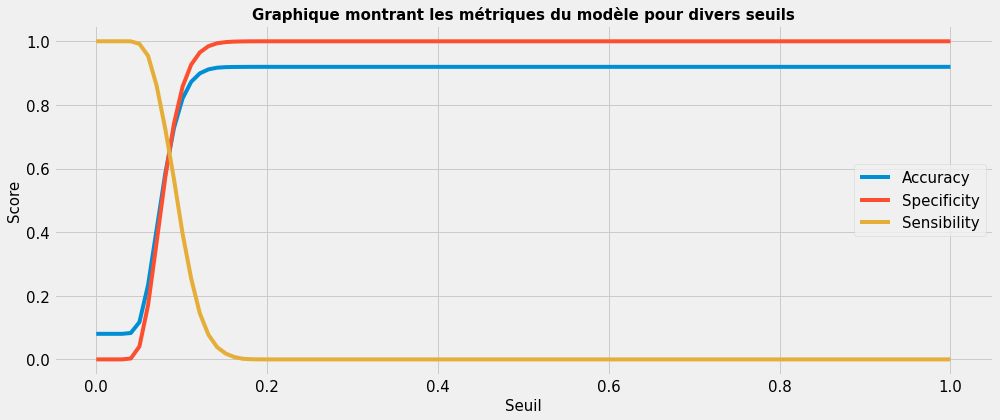

In [20]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



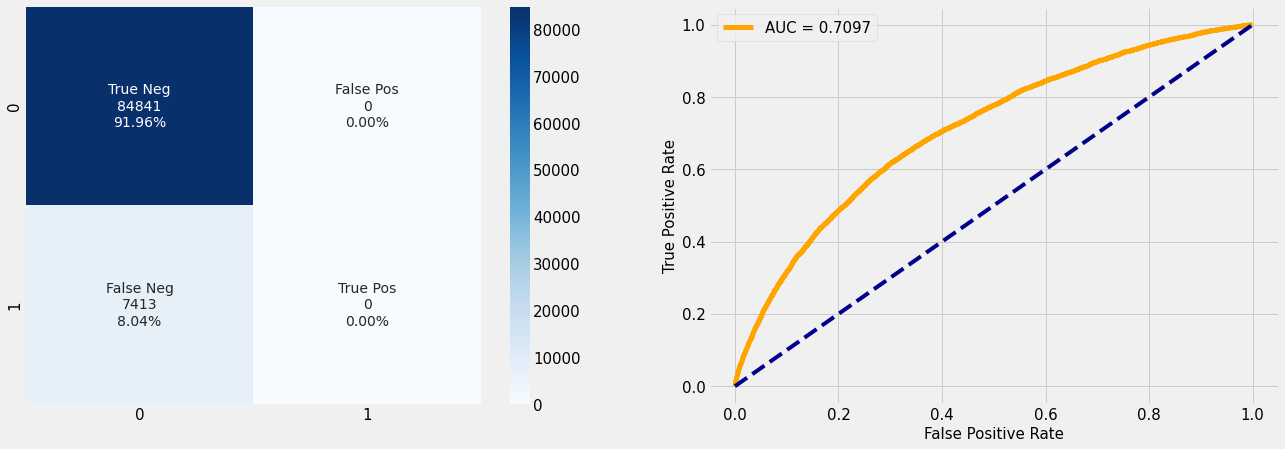

In [21]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling.predict(X_test)))
cf_matrix_roc_auc(log_modeling, y_test, log_modeling.predict(X_test), log_modeling.predict_proba(X_test)[:,1], feature_importances = None)

L'AUC est égal à 0.7097 qui signifie que ce modèle à une probabilité de 70,97% de distinguer correctement une classe négative d'une classe positive. En effet, notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

In [22]:
# Instanciation de l'algorithme
log_modeling_res = LogisticRegression(C = 0.0001, max_iter=100)

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_res.fit(X_train_res, y_train_res)

LogisticRegression(C=0.0001)

In [23]:
# Métriques de log_model pour divers seuils
df_metrics_model_res = print_results(log_modeling_res)
df_metrics_model_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.0,0.0,1.0
1,0.010101,0.080354,1.0,0.0,1.0
2,0.020202,0.080354,1.0,0.0,1.0
3,0.030303,0.080354,1.0,0.0,1.0
4,0.040404,0.080354,1.0,0.0,1.0


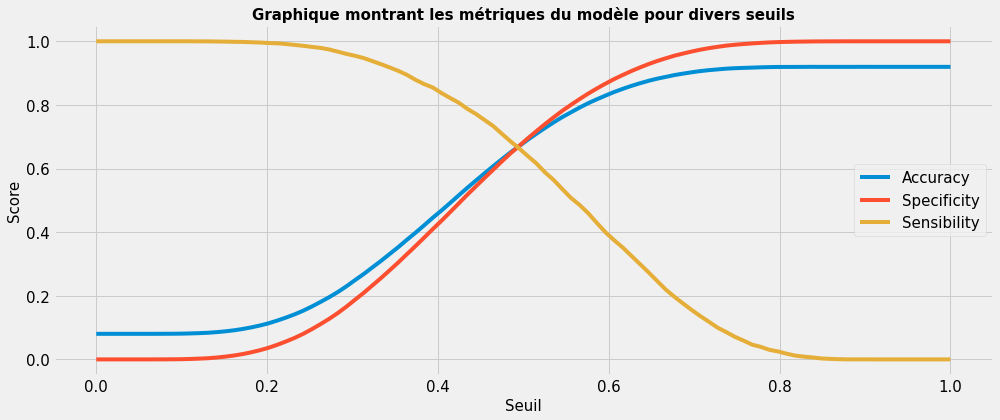

In [24]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_res)

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     84841
         1.0       0.15      0.65      0.25      7413

    accuracy                           0.68     92254
   macro avg       0.56      0.67      0.52     92254
weighted avg       0.89      0.68      0.75     92254



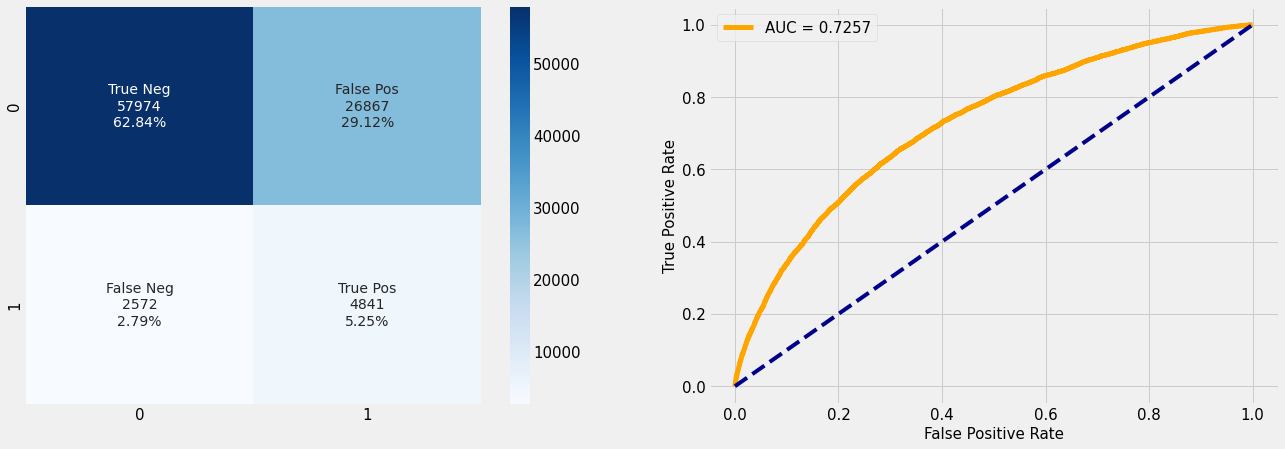

In [25]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_res, y_test, log_modeling_res.predict(X_test), log_modeling_res.predict_proba(X_test)[:,1], feature_importances = None)

Les courbes de score de classification, de sensiblité et de spécificité viennent se couper très proche d'un seui de 0,5. Cette ,ituation est différente de la courbe obtenu avec le modèle entraîné sur les données déséquilibrées où le point d'enterception est même inférieur à 0,2. On obserse une améloration de la performance du modèle sur les données équilibrées. Le modèle à une probabilité de 72,57% de distiquer une classe positive comme étant un classe positive et une classe négative comme étant une classe négative. Nous prendrons comme baseline de travail pour la suite des essais…

### <span style="color:#39ac39"> 4-2 Algorithme CatBoostClassifier </span>

In [26]:
#Import de l' algorithme
from catboost import CatBoostClassifier

In [27]:
# Instanciation de l'algorithme
log_catboost = CatBoostClassifier()

In [28]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_catboost.fit(X_train, y_train)

Learning rate set to 0.102119
0:	learn: 0.5955118	total: 819ms	remaining: 13m 37s
1:	learn: 0.5221672	total: 1.03s	remaining: 8m 36s
2:	learn: 0.4592741	total: 1.33s	remaining: 7m 23s
3:	learn: 0.4161858	total: 1.7s	remaining: 7m 3s
4:	learn: 0.3786738	total: 1.97s	remaining: 6m 31s
5:	learn: 0.3545694	total: 2.22s	remaining: 6m 8s
6:	learn: 0.3326514	total: 2.53s	remaining: 5m 58s
7:	learn: 0.3175693	total: 2.85s	remaining: 5m 54s
8:	learn: 0.3042365	total: 3.13s	remaining: 5m 45s
9:	learn: 0.2941561	total: 3.43s	remaining: 5m 39s
10:	learn: 0.2862919	total: 3.69s	remaining: 5m 32s
11:	learn: 0.2801228	total: 3.96s	remaining: 5m 26s
12:	learn: 0.2749582	total: 4.27s	remaining: 5m 24s
13:	learn: 0.2707444	total: 4.6s	remaining: 5m 23s
14:	learn: 0.2674234	total: 4.9s	remaining: 5m 21s
15:	learn: 0.2648235	total: 5.16s	remaining: 5m 17s
16:	learn: 0.2628012	total: 5.39s	remaining: 5m 11s
17:	learn: 0.2610294	total: 5.63s	remaining: 5m 7s
18:	learn: 0.2593985	total: 5.89s	remaining: 5m 4

158:	learn: 0.2342914	total: 46.6s	remaining: 4m 6s
159:	learn: 0.2342260	total: 46.9s	remaining: 4m 6s
160:	learn: 0.2341810	total: 47.1s	remaining: 4m 5s
161:	learn: 0.2341053	total: 47.3s	remaining: 4m 4s
162:	learn: 0.2340433	total: 47.8s	remaining: 4m 5s
163:	learn: 0.2339826	total: 48.3s	remaining: 4m 6s
164:	learn: 0.2338938	total: 49.2s	remaining: 4m 8s
165:	learn: 0.2338288	total: 49.5s	remaining: 4m 8s
166:	learn: 0.2337548	total: 49.9s	remaining: 4m 9s
167:	learn: 0.2336914	total: 50.3s	remaining: 4m 8s
168:	learn: 0.2336148	total: 50.9s	remaining: 4m 10s
169:	learn: 0.2336113	total: 51.4s	remaining: 4m 10s
170:	learn: 0.2335087	total: 51.7s	remaining: 4m 10s
171:	learn: 0.2334566	total: 52s	remaining: 4m 10s
172:	learn: 0.2333901	total: 52.3s	remaining: 4m 9s
173:	learn: 0.2333860	total: 52.4s	remaining: 4m 8s
174:	learn: 0.2333276	total: 52.9s	remaining: 4m 9s
175:	learn: 0.2332709	total: 53.2s	remaining: 4m 9s
176:	learn: 0.2332672	total: 53.5s	remaining: 4m 8s
177:	learn

313:	learn: 0.2261465	total: 1m 24s	remaining: 3m 5s
314:	learn: 0.2261046	total: 1m 25s	remaining: 3m 4s
315:	learn: 0.2260562	total: 1m 25s	remaining: 3m 4s
316:	learn: 0.2260082	total: 1m 25s	remaining: 3m 4s
317:	learn: 0.2259613	total: 1m 25s	remaining: 3m 4s
318:	learn: 0.2259029	total: 1m 26s	remaining: 3m 3s
319:	learn: 0.2258658	total: 1m 26s	remaining: 3m 3s
320:	learn: 0.2258066	total: 1m 26s	remaining: 3m 3s
321:	learn: 0.2257553	total: 1m 26s	remaining: 3m 2s
322:	learn: 0.2256892	total: 1m 27s	remaining: 3m 2s
323:	learn: 0.2256463	total: 1m 27s	remaining: 3m 2s
324:	learn: 0.2255924	total: 1m 27s	remaining: 3m 2s
325:	learn: 0.2255486	total: 1m 27s	remaining: 3m 1s
326:	learn: 0.2254937	total: 1m 28s	remaining: 3m 1s
327:	learn: 0.2254347	total: 1m 28s	remaining: 3m 1s
328:	learn: 0.2253887	total: 1m 28s	remaining: 3m
329:	learn: 0.2253347	total: 1m 28s	remaining: 3m
330:	learn: 0.2252952	total: 1m 29s	remaining: 3m
331:	learn: 0.2252560	total: 1m 29s	remaining: 2m 59s
3

466:	learn: 0.2195981	total: 1m 58s	remaining: 2m 15s
467:	learn: 0.2195487	total: 1m 59s	remaining: 2m 15s
468:	learn: 0.2195235	total: 1m 59s	remaining: 2m 15s
469:	learn: 0.2194649	total: 1m 59s	remaining: 2m 14s
470:	learn: 0.2194427	total: 1m 59s	remaining: 2m 14s
471:	learn: 0.2193910	total: 2m	remaining: 2m 14s
472:	learn: 0.2193498	total: 2m	remaining: 2m 14s
473:	learn: 0.2193126	total: 2m	remaining: 2m 13s
474:	learn: 0.2192756	total: 2m	remaining: 2m 13s
475:	learn: 0.2192374	total: 2m 1s	remaining: 2m 13s
476:	learn: 0.2191899	total: 2m 1s	remaining: 2m 12s
477:	learn: 0.2191542	total: 2m 1s	remaining: 2m 12s
478:	learn: 0.2191493	total: 2m 1s	remaining: 2m 12s
479:	learn: 0.2191138	total: 2m 1s	remaining: 2m 12s
480:	learn: 0.2190836	total: 2m 2s	remaining: 2m 11s
481:	learn: 0.2190511	total: 2m 2s	remaining: 2m 11s
482:	learn: 0.2189832	total: 2m 2s	remaining: 2m 11s
483:	learn: 0.2189532	total: 2m 2s	remaining: 2m 10s
484:	learn: 0.2189189	total: 2m 2s	remaining: 2m 10s


620:	learn: 0.2138004	total: 2m 34s	remaining: 1m 34s
621:	learn: 0.2137680	total: 2m 34s	remaining: 1m 33s
622:	learn: 0.2137296	total: 2m 34s	remaining: 1m 33s
623:	learn: 0.2137045	total: 2m 35s	remaining: 1m 33s
624:	learn: 0.2136824	total: 2m 35s	remaining: 1m 33s
625:	learn: 0.2136616	total: 2m 35s	remaining: 1m 32s
626:	learn: 0.2136311	total: 2m 35s	remaining: 1m 32s
627:	learn: 0.2136084	total: 2m 35s	remaining: 1m 32s
628:	learn: 0.2135719	total: 2m 36s	remaining: 1m 32s
629:	learn: 0.2135231	total: 2m 36s	remaining: 1m 31s
630:	learn: 0.2134794	total: 2m 36s	remaining: 1m 31s
631:	learn: 0.2134582	total: 2m 36s	remaining: 1m 31s
632:	learn: 0.2134167	total: 2m 37s	remaining: 1m 31s
633:	learn: 0.2133968	total: 2m 37s	remaining: 1m 30s
634:	learn: 0.2133647	total: 2m 37s	remaining: 1m 30s
635:	learn: 0.2133331	total: 2m 37s	remaining: 1m 30s
636:	learn: 0.2132900	total: 2m 37s	remaining: 1m 29s
637:	learn: 0.2132506	total: 2m 37s	remaining: 1m 29s
638:	learn: 0.2132481	total:

776:	learn: 0.2083938	total: 3m 9s	remaining: 54.3s
777:	learn: 0.2083806	total: 3m 9s	remaining: 54s
778:	learn: 0.2083534	total: 3m 9s	remaining: 53.7s
779:	learn: 0.2083054	total: 3m 9s	remaining: 53.5s
780:	learn: 0.2082912	total: 3m 9s	remaining: 53.2s
781:	learn: 0.2082697	total: 3m 10s	remaining: 53s
782:	learn: 0.2082322	total: 3m 10s	remaining: 52.7s
783:	learn: 0.2081832	total: 3m 10s	remaining: 52.5s
784:	learn: 0.2081500	total: 3m 10s	remaining: 52.3s
785:	learn: 0.2081013	total: 3m 11s	remaining: 52s
786:	learn: 0.2080686	total: 3m 11s	remaining: 51.8s
787:	learn: 0.2080231	total: 3m 11s	remaining: 51.5s
788:	learn: 0.2079960	total: 3m 11s	remaining: 51.3s
789:	learn: 0.2079648	total: 3m 11s	remaining: 51s
790:	learn: 0.2079459	total: 3m 12s	remaining: 50.7s
791:	learn: 0.2079302	total: 3m 12s	remaining: 50.5s
792:	learn: 0.2079056	total: 3m 12s	remaining: 50.3s
793:	learn: 0.2078674	total: 3m 12s	remaining: 50s
794:	learn: 0.2078407	total: 3m 12s	remaining: 49.7s
795:	lea

932:	learn: 0.2032379	total: 3m 45s	remaining: 16.2s
933:	learn: 0.2031952	total: 3m 45s	remaining: 15.9s
934:	learn: 0.2031708	total: 3m 45s	remaining: 15.7s
935:	learn: 0.2031424	total: 3m 45s	remaining: 15.4s
936:	learn: 0.2031047	total: 3m 46s	remaining: 15.2s
937:	learn: 0.2030559	total: 3m 46s	remaining: 15s
938:	learn: 0.2030478	total: 3m 46s	remaining: 14.7s
939:	learn: 0.2030205	total: 3m 46s	remaining: 14.5s
940:	learn: 0.2029790	total: 3m 46s	remaining: 14.2s
941:	learn: 0.2029468	total: 3m 47s	remaining: 14s
942:	learn: 0.2029400	total: 3m 47s	remaining: 13.7s
943:	learn: 0.2029122	total: 3m 47s	remaining: 13.5s
944:	learn: 0.2028889	total: 3m 47s	remaining: 13.3s
945:	learn: 0.2028609	total: 3m 48s	remaining: 13s
946:	learn: 0.2028399	total: 3m 48s	remaining: 12.8s
947:	learn: 0.2027919	total: 3m 48s	remaining: 12.5s
948:	learn: 0.2027395	total: 3m 48s	remaining: 12.3s
949:	learn: 0.2027054	total: 3m 49s	remaining: 12.1s
950:	learn: 0.2026750	total: 3m 49s	remaining: 11.8s

In [29]:
# Métriques de log_model pour divers seuils
df_metrics_model_cat = print_results(log_catboost)
df_metrics_model_cat.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.134097,0.995279,0.058851,0.941149
2,0.020202,0.273105,0.967759,0.212409,0.787591
3,0.030303,0.402844,0.931472,0.356655,0.643345
4,0.040404,0.504141,0.883988,0.470952,0.529048


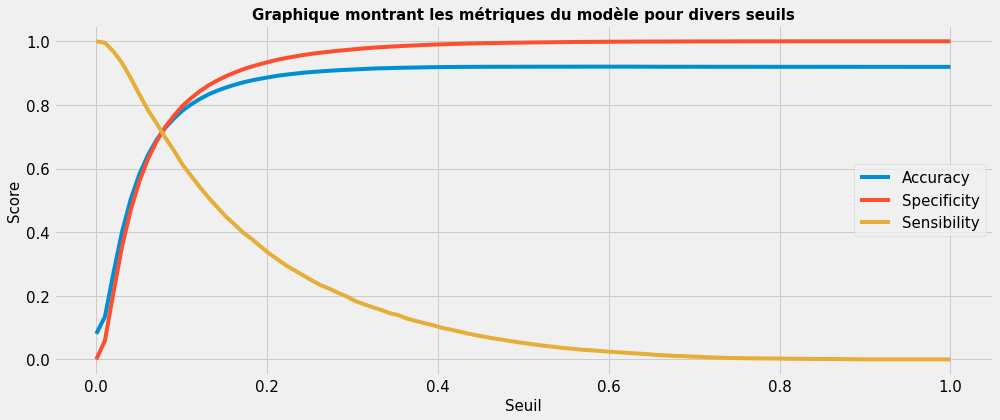

In [30]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_cat)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.53      0.05      0.09      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.52      0.53     92254
weighted avg       0.89      0.92      0.89     92254



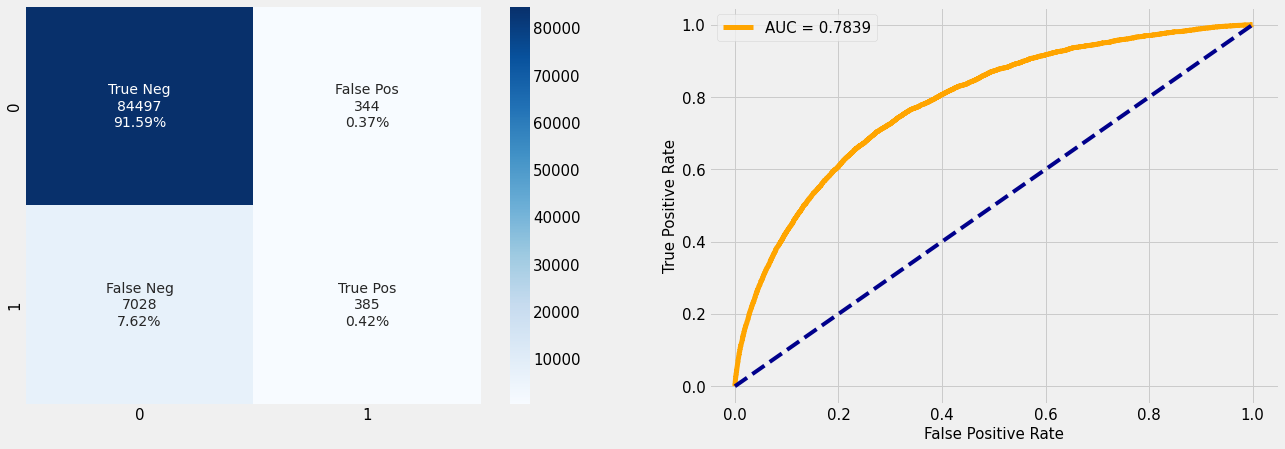

In [31]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_catboost.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_catboost.predict(X_test)))
cf_matrix_roc_auc(log_catboost, y_test, log_catboost.predict(X_test), log_catboost.predict_proba(X_test)[:,1], feature_importances = None)

**Oversampling Data Using SMOTE**

In [32]:
# Instanciation de l'algorithme
log_modeling_catboost_res = CatBoostClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_catboost_res.fit(X_train_res, y_train_res)

Learning rate set to 0.132436
0:	learn: 0.6066927	total: 802ms	remaining: 13m 21s
1:	learn: 0.5710167	total: 1.46s	remaining: 12m 7s
2:	learn: 0.5432528	total: 2.1s	remaining: 11m 37s
3:	learn: 0.4961675	total: 2.74s	remaining: 11m 21s
4:	learn: 0.4453306	total: 3.66s	remaining: 12m 8s
5:	learn: 0.4304199	total: 4.63s	remaining: 12m 46s
6:	learn: 0.4167989	total: 5.27s	remaining: 12m 27s
7:	learn: 0.3909045	total: 5.97s	remaining: 12m 20s
8:	learn: 0.3628263	total: 6.75s	remaining: 12m 23s
9:	learn: 0.3476638	total: 7.47s	remaining: 12m 19s
10:	learn: 0.3209585	total: 8.19s	remaining: 12m 16s
11:	learn: 0.3127424	total: 8.97s	remaining: 12m 18s
12:	learn: 0.2868553	total: 9.67s	remaining: 12m 14s
13:	learn: 0.2701275	total: 10.3s	remaining: 12m 2s
14:	learn: 0.2644060	total: 10.8s	remaining: 11m 52s
15:	learn: 0.2545512	total: 11.6s	remaining: 11m 55s
16:	learn: 0.2494410	total: 12.2s	remaining: 11m 46s
17:	learn: 0.2366813	total: 12.8s	remaining: 11m 40s
18:	learn: 0.2257289	total: 13

155:	learn: 0.1355433	total: 1m 42s	remaining: 9m 15s
156:	learn: 0.1354971	total: 1m 43s	remaining: 9m 13s
157:	learn: 0.1354125	total: 1m 43s	remaining: 9m 13s
158:	learn: 0.1353404	total: 1m 44s	remaining: 9m 12s
159:	learn: 0.1352784	total: 1m 45s	remaining: 9m 11s
160:	learn: 0.1352335	total: 1m 45s	remaining: 9m 10s
161:	learn: 0.1351804	total: 1m 46s	remaining: 9m 8s
162:	learn: 0.1348152	total: 1m 46s	remaining: 9m 7s
163:	learn: 0.1347685	total: 1m 47s	remaining: 9m 5s
164:	learn: 0.1347352	total: 1m 47s	remaining: 9m 4s
165:	learn: 0.1346796	total: 1m 47s	remaining: 9m 2s
166:	learn: 0.1346061	total: 1m 48s	remaining: 9m 2s
167:	learn: 0.1345695	total: 1m 49s	remaining: 9m
168:	learn: 0.1345034	total: 1m 49s	remaining: 8m 59s
169:	learn: 0.1344557	total: 1m 50s	remaining: 8m 59s
170:	learn: 0.1344161	total: 1m 51s	remaining: 8m 58s
171:	learn: 0.1343480	total: 1m 51s	remaining: 8m 57s
172:	learn: 0.1342979	total: 1m 52s	remaining: 8m 56s
173:	learn: 0.1342348	total: 1m 53s	re

309:	learn: 0.1281506	total: 3m 7s	remaining: 6m 57s
310:	learn: 0.1281172	total: 3m 7s	remaining: 6m 56s
311:	learn: 0.1280684	total: 3m 8s	remaining: 6m 56s
312:	learn: 0.1280240	total: 3m 9s	remaining: 6m 55s
313:	learn: 0.1279691	total: 3m 9s	remaining: 6m 54s
314:	learn: 0.1279280	total: 3m 10s	remaining: 6m 53s
315:	learn: 0.1278921	total: 3m 10s	remaining: 6m 53s
316:	learn: 0.1278504	total: 3m 11s	remaining: 6m 52s
317:	learn: 0.1278077	total: 3m 11s	remaining: 6m 51s
318:	learn: 0.1277609	total: 3m 12s	remaining: 6m 50s
319:	learn: 0.1277341	total: 3m 12s	remaining: 6m 49s
320:	learn: 0.1277051	total: 3m 13s	remaining: 6m 48s
321:	learn: 0.1276655	total: 3m 13s	remaining: 6m 47s
322:	learn: 0.1276319	total: 3m 14s	remaining: 6m 47s
323:	learn: 0.1276165	total: 3m 14s	remaining: 6m 46s
324:	learn: 0.1275875	total: 3m 15s	remaining: 6m 45s
325:	learn: 0.1275447	total: 3m 16s	remaining: 6m 45s
326:	learn: 0.1275228	total: 3m 17s	remaining: 6m 45s
327:	learn: 0.1275204	total: 3m 1

462:	learn: 0.1228639	total: 4m 27s	remaining: 5m 10s
463:	learn: 0.1228247	total: 4m 31s	remaining: 5m 14s
464:	learn: 0.1227892	total: 4m 32s	remaining: 5m 13s
465:	learn: 0.1227686	total: 4m 33s	remaining: 5m 13s
466:	learn: 0.1227428	total: 4m 33s	remaining: 5m 12s
467:	learn: 0.1227061	total: 4m 34s	remaining: 5m 12s
468:	learn: 0.1226876	total: 4m 35s	remaining: 5m 11s
469:	learn: 0.1226471	total: 4m 36s	remaining: 5m 11s
470:	learn: 0.1226301	total: 4m 36s	remaining: 5m 10s
471:	learn: 0.1225997	total: 4m 37s	remaining: 5m 10s
472:	learn: 0.1225763	total: 4m 38s	remaining: 5m 9s
473:	learn: 0.1225425	total: 4m 38s	remaining: 5m 9s
474:	learn: 0.1225203	total: 4m 39s	remaining: 5m 8s
475:	learn: 0.1224816	total: 4m 40s	remaining: 5m 8s
476:	learn: 0.1224634	total: 4m 41s	remaining: 5m 8s
477:	learn: 0.1224424	total: 4m 41s	remaining: 5m 7s
478:	learn: 0.1224207	total: 4m 42s	remaining: 5m 6s
479:	learn: 0.1223959	total: 4m 42s	remaining: 5m 6s
480:	learn: 0.1223761	total: 4m 43s	

615:	learn: 0.1187484	total: 5m 58s	remaining: 3m 43s
616:	learn: 0.1187234	total: 5m 59s	remaining: 3m 42s
617:	learn: 0.1186863	total: 5m 59s	remaining: 3m 42s
618:	learn: 0.1186612	total: 6m	remaining: 3m 41s
619:	learn: 0.1186426	total: 6m 1s	remaining: 3m 41s
620:	learn: 0.1186106	total: 6m 1s	remaining: 3m 40s
621:	learn: 0.1185834	total: 6m 2s	remaining: 3m 40s
622:	learn: 0.1185722	total: 6m 2s	remaining: 3m 39s
623:	learn: 0.1184220	total: 6m 3s	remaining: 3m 38s
624:	learn: 0.1183983	total: 6m 3s	remaining: 3m 38s
625:	learn: 0.1183587	total: 6m 4s	remaining: 3m 37s
626:	learn: 0.1183342	total: 6m 4s	remaining: 3m 36s
627:	learn: 0.1183162	total: 6m 5s	remaining: 3m 36s
628:	learn: 0.1182958	total: 6m 5s	remaining: 3m 35s
629:	learn: 0.1182677	total: 6m 6s	remaining: 3m 35s
630:	learn: 0.1182477	total: 6m 6s	remaining: 3m 34s
631:	learn: 0.1182125	total: 6m 7s	remaining: 3m 33s
632:	learn: 0.1181868	total: 6m 8s	remaining: 3m 33s
633:	learn: 0.1181672	total: 6m 8s	remaining: 

768:	learn: 0.1149822	total: 7m 22s	remaining: 2m 12s
769:	learn: 0.1149602	total: 7m 22s	remaining: 2m 12s
770:	learn: 0.1149333	total: 7m 23s	remaining: 2m 11s
771:	learn: 0.1149152	total: 7m 23s	remaining: 2m 11s
772:	learn: 0.1148972	total: 7m 24s	remaining: 2m 10s
773:	learn: 0.1148921	total: 7m 24s	remaining: 2m 9s
774:	learn: 0.1148749	total: 7m 25s	remaining: 2m 9s
775:	learn: 0.1148499	total: 7m 26s	remaining: 2m 8s
776:	learn: 0.1148175	total: 7m 26s	remaining: 2m 8s
777:	learn: 0.1148091	total: 7m 27s	remaining: 2m 7s
778:	learn: 0.1147916	total: 7m 27s	remaining: 2m 7s
779:	learn: 0.1147692	total: 7m 28s	remaining: 2m 6s
780:	learn: 0.1147552	total: 7m 28s	remaining: 2m 5s
781:	learn: 0.1147312	total: 7m 29s	remaining: 2m 5s
782:	learn: 0.1147172	total: 7m 29s	remaining: 2m 4s
783:	learn: 0.1146895	total: 7m 30s	remaining: 2m 4s
784:	learn: 0.1146785	total: 7m 30s	remaining: 2m 3s
785:	learn: 0.1146566	total: 7m 31s	remaining: 2m 2s
786:	learn: 0.1146552	total: 7m 31s	remai

922:	learn: 0.1116926	total: 8m 46s	remaining: 43.9s
923:	learn: 0.1116668	total: 8m 46s	remaining: 43.3s
924:	learn: 0.1116521	total: 8m 47s	remaining: 42.8s
925:	learn: 0.1116394	total: 8m 48s	remaining: 42.2s
926:	learn: 0.1116070	total: 8m 48s	remaining: 41.6s
927:	learn: 0.1115894	total: 8m 49s	remaining: 41.1s
928:	learn: 0.1115680	total: 8m 49s	remaining: 40.5s
929:	learn: 0.1115562	total: 8m 50s	remaining: 39.9s
930:	learn: 0.1115259	total: 8m 50s	remaining: 39.3s
931:	learn: 0.1115003	total: 8m 51s	remaining: 38.8s
932:	learn: 0.1114704	total: 8m 51s	remaining: 38.2s
933:	learn: 0.1114458	total: 8m 52s	remaining: 37.6s
934:	learn: 0.1114162	total: 8m 53s	remaining: 37.1s
935:	learn: 0.1113858	total: 8m 53s	remaining: 36.5s
936:	learn: 0.1113846	total: 8m 54s	remaining: 35.9s
937:	learn: 0.1113537	total: 8m 54s	remaining: 35.3s
938:	learn: 0.1113245	total: 8m 55s	remaining: 34.8s
939:	learn: 0.1112954	total: 8m 55s	remaining: 34.2s
940:	learn: 0.1112731	total: 8m 56s	remaining:

In [33]:
# Métriques de log_model pour divers seuils
df_metrics_model_catboost_res = print_results(log_modeling_catboost_res)
df_metrics_model_catboost_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.00000,0.000000,1.000000
1,0.010101,0.148134,0.99312,0.074304,0.925696
2,0.020202,0.276096,0.96695,0.215733,0.784267
3,0.030303,0.391907,0.92729,0.345128,0.654872
4,0.040404,0.485605,0.88790,0.450454,0.549546


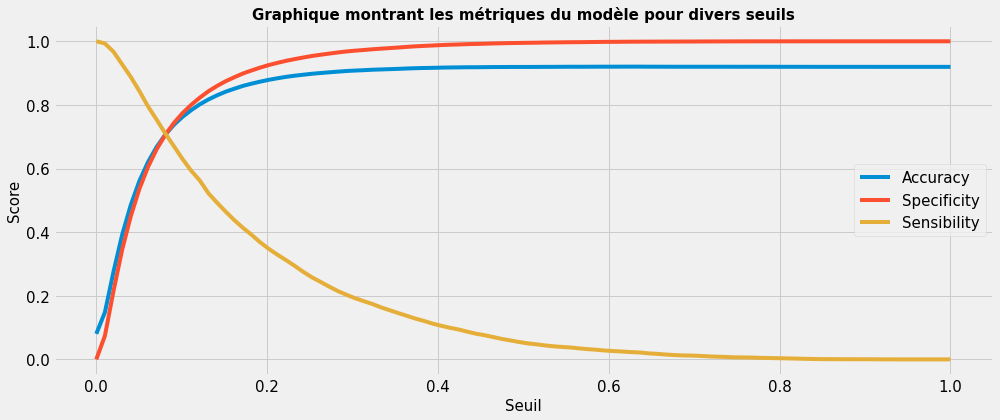

In [34]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_catboost_res)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.48      0.05      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.70      0.52      0.53     92254
weighted avg       0.89      0.92      0.89     92254



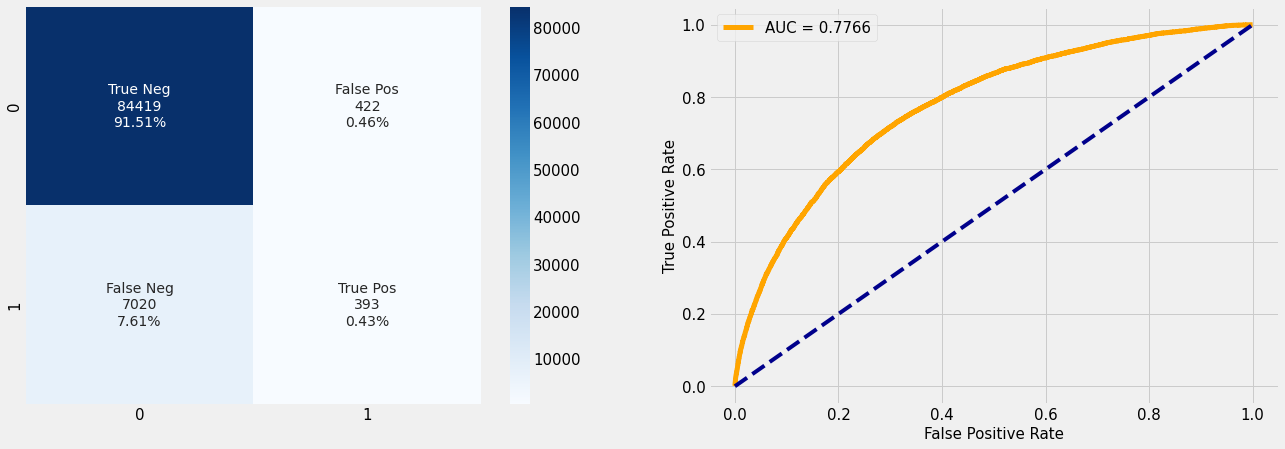

In [35]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_catboost_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_catboost_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_catboost_res, y_test, log_modeling_catboost_res.predict(X_test), log_modeling_catboost_res.predict_proba(X_test)[:,1], feature_importances = None)

### <span style="color:#39ac39"> 4-3 Algorithme LGBMClassifier </span>

In [36]:
#Import de l' algorithme
from lightgbm import LGBMClassifier

In [37]:
# Instanciation de l'algorithme
log_LGBM = LGBMClassifier()

In [38]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_LGBM.fit(X_train, y_train)

LGBMClassifier()

In [39]:
# Métriques de log_model pour divers seuils
df_metrics_model_lgbm = print_results(log_LGBM)
df_metrics_model_lgbm.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.089535,0.999730,0.010007,0.989993
2,0.020202,0.211492,0.983003,0.144081,0.855919
3,0.030303,0.363616,0.943747,0.312927,0.687073
4,0.040404,0.481844,0.891407,0.446058,0.553942


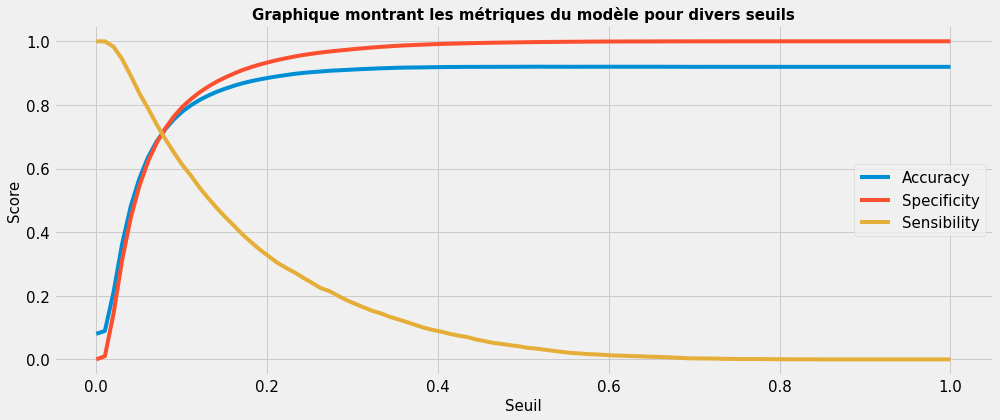

In [40]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_lgbm)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.53      0.04      0.07      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.52      0.52     92254
weighted avg       0.89      0.92      0.89     92254



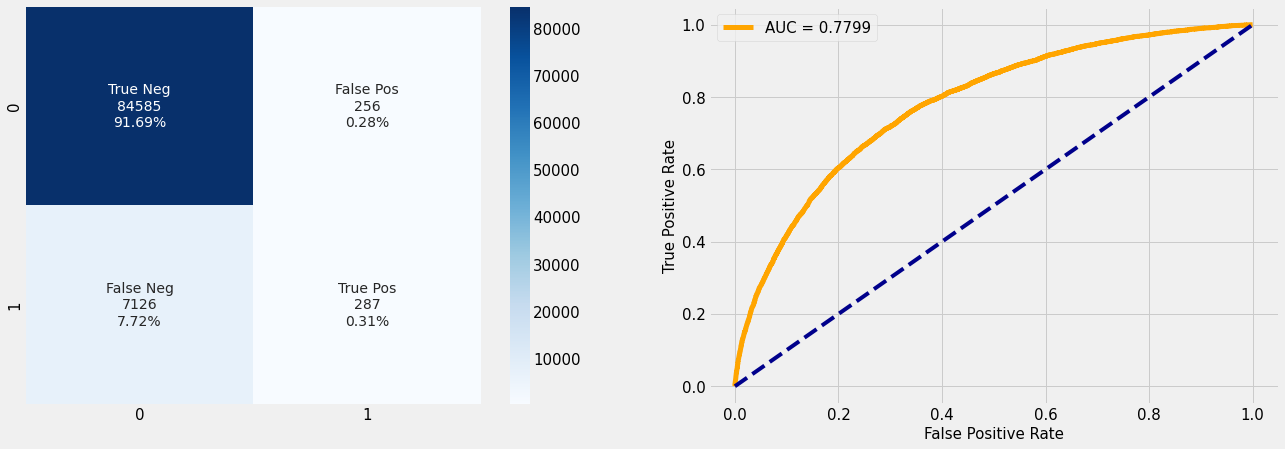

In [41]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_LGBM.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_LGBM.predict(X_test)))
cf_matrix_roc_auc(log_LGBM, y_test, log_LGBM.predict(X_test), log_LGBM.predict_proba(X_test)[:,1], feature_importances = None)

**Oversampling Data Using SMOTE**

In [42]:
# Instanciation de l'algorithme
log_modeling_LGBM_res = LGBMClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_LGBM_res.fit(X_train_res, y_train_res)

LGBMClassifier()

In [43]:
# Métriques de log_model pour divers seuils
df_metrics_model_LGBM_res = print_results(log_modeling_LGBM_res)
df_metrics_model_LGBM_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.080885,1.000000,0.000578,0.999422
2,0.020202,0.132796,0.993525,0.057590,0.942410
3,0.030303,0.242721,0.971671,0.179029,0.820971
4,0.040404,0.351313,0.936733,0.300161,0.699839


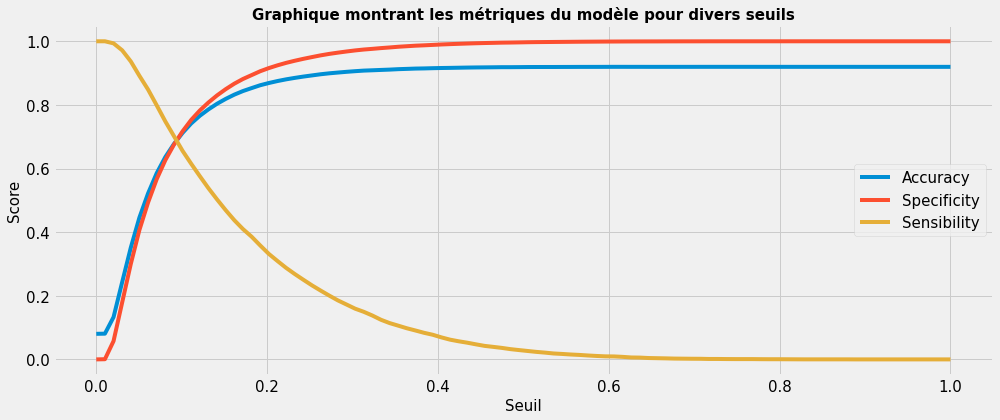

In [44]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_LGBM_res)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.43      0.03      0.05      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.51      0.51     92254
weighted avg       0.88      0.92      0.88     92254



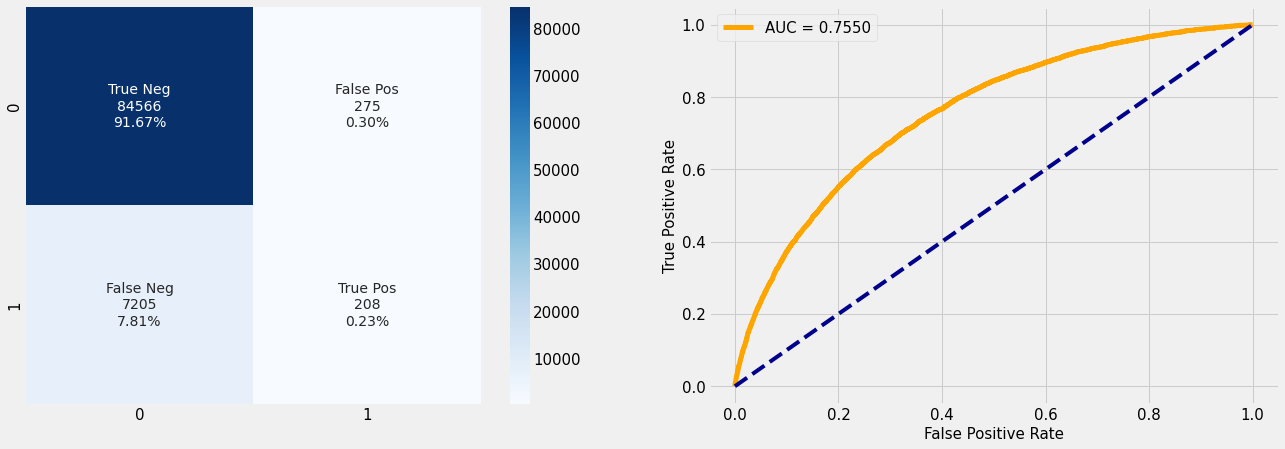

In [45]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_LGBM_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_LGBM_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_LGBM_res, y_test, log_modeling_LGBM_res.predict(X_test), log_modeling_LGBM_res.predict_proba(X_test)[:,1], feature_importances = None)

### <span style="color:#39ac39"> 4-4 Algorithme XGBClassifier </span>

In [46]:
#Import de l' algorithme
from xgboost import XGBClassifier

In [47]:
# Instanciation de l'algorithme
log_XGB = XGBClassifier()

In [48]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [49]:
# Métriques de log_model pour divers seuils
df_metrics_model_XGB = print_results(log_XGB)
df_metrics_model_XGB.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.164361,0.988803,0.092326,0.907674
2,0.020202,0.315835,0.953865,0.260087,0.739913
3,0.030303,0.442127,0.905436,0.401645,0.598355
4,0.040404,0.536996,0.856603,0.509070,0.490930


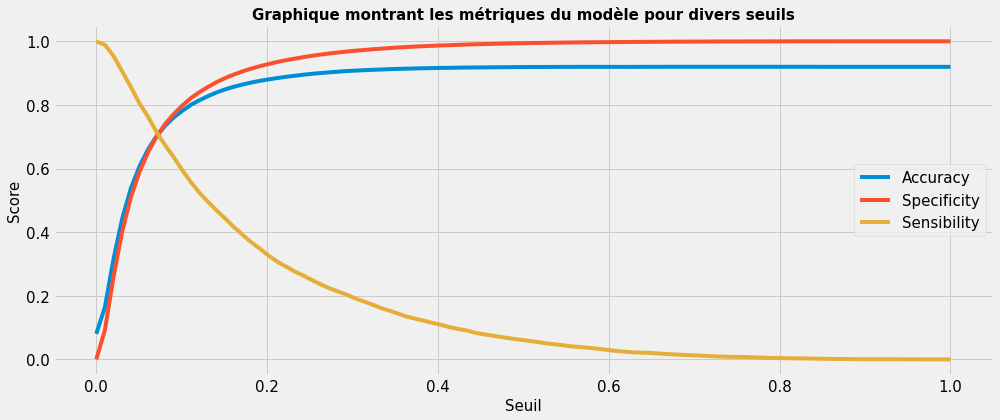

In [50]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_XGB)

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.47      0.06      0.11      7413

    accuracy                           0.92     92254
   macro avg       0.70      0.53      0.53     92254
weighted avg       0.89      0.92      0.89     92254



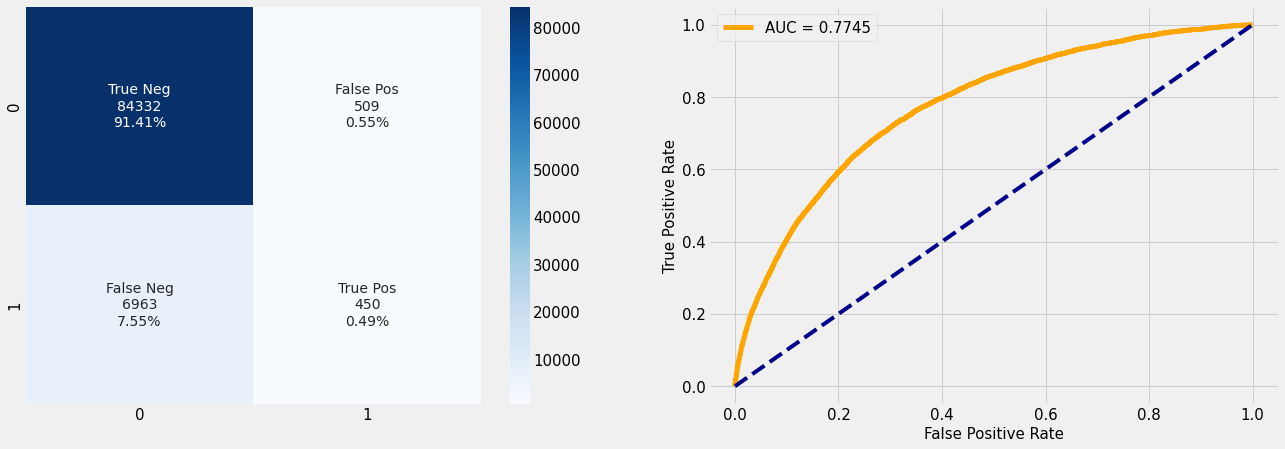

In [51]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_XGB.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_XGB.predict(X_test)))
cf_matrix_roc_auc(log_XGB, y_test, log_XGB.predict(X_test), log_XGB.predict_proba(X_test)[:,1], feature_importances = None)

**Oversampling Data Using SMOTE**

In [52]:
# Instanciation de l'algorithme
log_modeling_XGB_res = XGBClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_XGB_res.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [53]:
# Métriques de log_model pour divers seuils
df_metrics_model_XGB_res = print_results(log_modeling_XGB_res)
df_metrics_model_XGB_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.180567,0.986240,0.110171,0.889829
2,0.020202,0.321926,0.943343,0.267630,0.732370
3,0.030303,0.433531,0.892351,0.393442,0.606558
4,0.040404,0.518568,0.844193,0.490117,0.509883


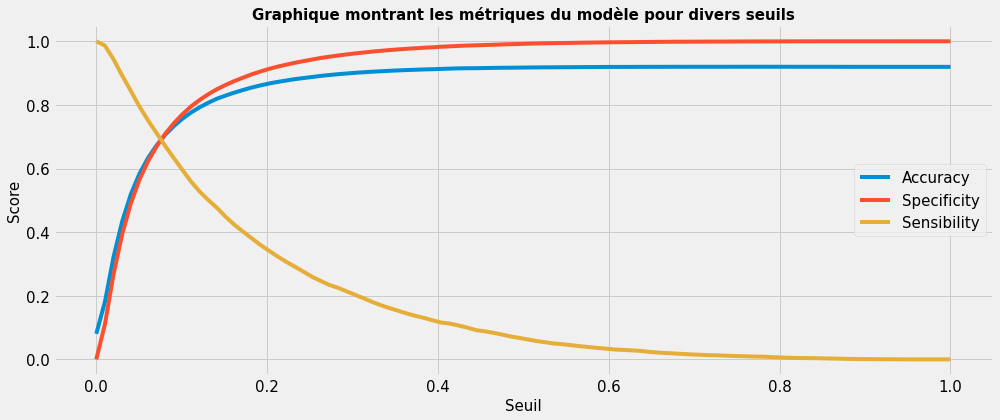

In [54]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_XGB_res)

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.41      0.07      0.11      7413

    accuracy                           0.92     92254
   macro avg       0.67      0.53      0.53     92254
weighted avg       0.88      0.92      0.89     92254



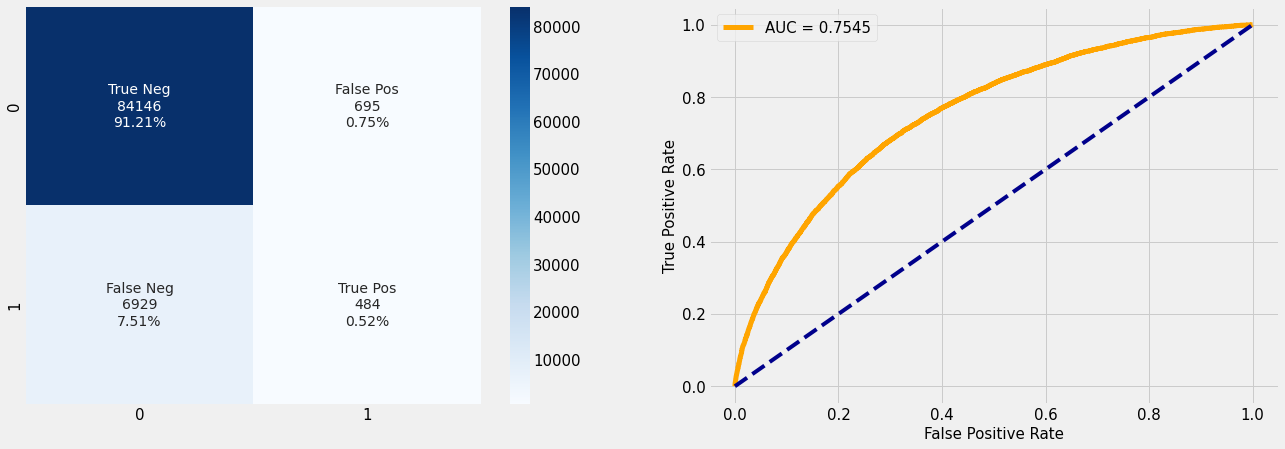

In [55]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_XGB_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_XGB_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_XGB_res, y_test, log_modeling_XGB_res.predict(X_test), log_modeling_XGB_res.predict_proba(X_test)[:,1], feature_importances = None)

### <span style="color:#39ac39"> 4-5 Feature Selection - Recursive Feature Elimination </span>

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC  tout en éliminant les features les moins importantes.

#### Optimisation des différents algorithmes en utilisant la fonction GriSearchCV via la méthode de validation croisée

Un hyperparamètre est une donnée externe à l’algorithme ne pouvant être mise à jour lors des apprentissages. A cet effet, Pour trouver la valeur de l'hyperparamètre optimal dans le présent travail pour chaque algorithmes, nous allons utiliser la fonction GriSearchCV qui va ensuite utiliser les données d'apprentissage pour trouver la meilleure optimisation des hyperparamètres en utilisant la méthode de validation croisée. C’est-à-dire qu’elle va, dans notre cas, découper les données d’apprentissage en 5 groupes (CV=5), déterminer une optimisation sur les quatre premiers groupes et tester sur le cinquième.

In [73]:
###Importation du module
from sklearn.model_selection import GridSearchCV

In [74]:
###Instanciation de l'algorithme
log_modeling_LGBM = LGBMClassifier()

In [61]:
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 504 features.
Fitting estimator with 499 features.
Fitting estimator with 494 features.
Fitting estimator with 489 features.
Fitting estimator with 484 features.
Fitting estimator with 479 features.
Fitting estimator with 474 features.
Fitting estimator with 469 features.
Fitting estimator with 464 features.
Fitting estimator with 459 features.
Fitting estimator with 454 features.
Fitting estimator with 449 features.
Fitting estimator with 444 features.
Fitting estimator with 439 features.
Fitting estimator with 434 features.
Fitting estimator with 429 features.
Fitting estimator with 424 features.
Fitting estimator with 419 features.
Fitting estimator with 414 features.
Fitting estimator with 409 features.
Fitting estimator with 404 features.
Fitting estimator with 399 features.
Fitting estimator with 394 features.
Fitting estimator with 389 features.
Fitting estimator with 384 features.
Fitting estimator with 379 features.
Fitting estimator with 374 features.
F

In [79]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 234
Selected Features: [ True  True False  True  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Feature Ranking : [ 1  1 18  1  1  1  1  1  1  1  1  1  1  1 19 19  1 16  7 19]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [80]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

234
['NAME_CONTRACT_TYPE', 'CC_BAL_AMT_BALANCE', 'TY__Mortgage', 'CC_BAL_MONTHS_BALANCE', 'CC_BAL_SK_ID_PREV', 'AVG_PREV_PREVIOUS_APPLICATION_COUNT', 'AVG_PREV_AMT_ANNUITY', 'AVG_PREV_AMT_APPLICATION', 'AVG_PREV_AMT_CREDIT', 'AVG_PREV_AMT_DOWN_PAYMENT', 'AVG_PREV_AMT_GOODS_PRICE', 'AVG_PREV_HOUR_APPR_PROCESS_START', 'AVG_PREV_PRODUCT_COMBINATION_POS mobile without interest', 'AVG_PREV_NFLAG_LAST_APPL_IN_DAY', 'AVG_PREV_RATE_DOWN_PAYMENT', 'AVG_PREV_PRODUCT_COMBINATION_POS industry with interest', 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: middle', 'AVG_PREV_DAYS_DECISION', 'AVG_PREV_SELLERPLACE_AREA', 'AVG_PREV_CNT_PAYMENT', 'AVG_PREV_DAYS_FIRST_DRAWING', 'AVG_PREV_DAYS_FIRST_DUE', 'AVG_PREV_DAYS_LAST_DUE_1ST_VERSION', 'AVG_PREV_DAYS_LAST_DUE', 'AVG_PREV_DAYS_TERMINATION', 'AVG_PREV_NFLAG_INSURED_ON_APPROVAL', 'TY__Microloan', 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: low', 'CC_BAL_AMT_CREDIT_LIMIT_ACTUAL', 'WALLSMATERIAL_MODE_Panel', 'AVG_BURO_MONTHS_BALANCE_MEAN', 'AVG_BURO_BURO_BAL

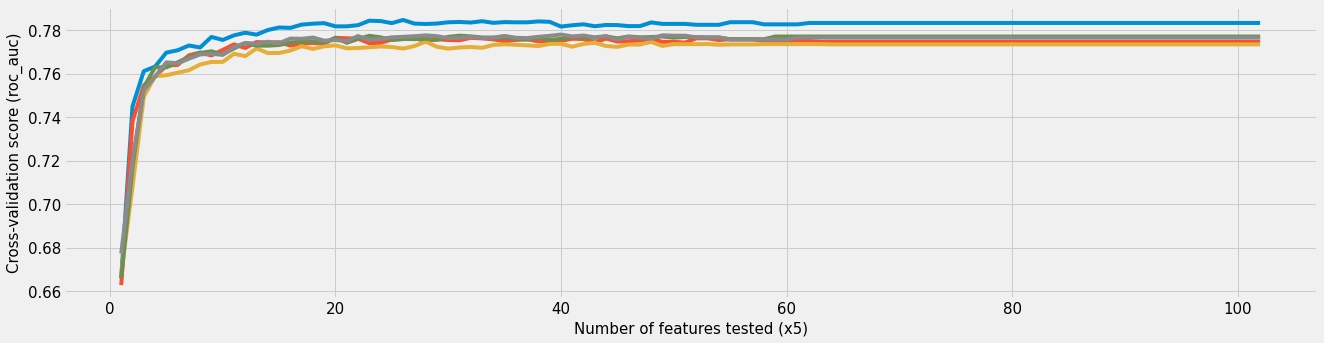

In [81]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()

In [67]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 234)

In [68]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [69]:
X_data.shape

(307511, 235)

In [70]:
X_data.head(5)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP_high,AVG_P

In [71]:
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_dashbord/X_data.zip', index=True, compression=compression_opts)

In [72]:
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_dashbord/X_sample.zip', index=True, compression=compression_opts)

In [125]:
z = ZipFile("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_dashbord/X_sample.zip")
sample_df = pd.read_csv(z.open('X_sample.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
sample_df.shape

(30000, 235)

In [126]:
sample_df.head(3)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP_high,AVG_P

In [127]:
X_sample_df_copy = sample_df.copy()
X_sample_df_copy = X_sample_df_copy.reset_index()
print(X_sample_df_copy.shape)
X_sample_df_copy.head(2)

(30000, 236)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP

In [128]:
X_sample_df_copy.drop('SK_ID_CURR', axis=1, inplace=True)
print(X_sample_df_copy.shape)
X_sample_df_copy.head(2)

(30000, 235)


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP_high,AVG_P

In [122]:
z = ZipFile("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/df_train_ma.zip")
df_train_ma = pd.read_csv(z.open('df_train_ma.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
print(df_train_ma.shape)
df_train_ma.head(5)

(307511, 504)


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_3,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Bad debt,CA__Closed,CA__Sold,CU__currency 1,CU__currency 2,CU__currency 3,CU__currency 4,TY__Another type of loan,TY__Car loan,TY__Cash loan (non-earmarked),TY__Consumer credit,TY__Credit card,TY__Interbank credit,TY__Loan for business development,TY__Loan for purchase of shares (margin lending),TY__Loan for the purchase of equipment,TY__Loan for working capital replenishment,TY__Microloan,TY__Mobile operator loan,TY__Mortgage,TY__Real estate loan,TY__Unknown type of loan,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_FLAG_LAST_APPL_PER_CONTRACT,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_RATE_INTEREST_PRIMARY,AVG_PREV_RATE_INTEREST_PRIVILEGED,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Cash loans,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_NAME_CONTRACT_TYPE_XNA,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_C

In [132]:
#Merge operation with TARGET before save this reduced sample
df_train_ma = df_train_ma.merge(TARGET, left_index=True, right_index=True)
print(df_train_ma.shape)
df_train_ma.head(5)

(307511, 505)


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_3,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Bad debt,CA__Closed,CA__Sold,CU__currency 1,CU__currency 2,CU__currency 3,CU__currency 4,TY__Another type of loan,TY__Car loan,TY__Cash loan (non-earmarked),TY__Consumer credit,TY__Credit card,TY__Interbank credit,TY__Loan for business development,TY__Loan for purchase of shares (margin lending),TY__Loan for the purchase of equipment,TY__Loan for working capital replenishment,TY__Microloan,TY__Mobile operator loan,TY__Mortgage,TY__Real estate loan,TY__Unknown type of loan,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_FLAG_LAST_APPL_PER_CONTRACT,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_RATE_INTEREST_PRIMARY,AVG_PREV_RATE_INTEREST_PRIVILEGED,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Cash loans,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_NAME_CONTRACT_TYPE_XNA,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_C

In [133]:
#X_data is very important to implement the feature importance plot...
default_risk_ma = df_train_ma.loc[list(sample_df.reset_index().SK_ID_CURR), list(X_sample_df_copy.columns)]
print(default_risk_ma.shape)
default_risk_ma.head(5)

(30000, 235)


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP_high,AVG_P

In [ ]:
default_risk_ma['NAME_CONTRACT_TYPE'].value_counts()

In [147]:
default_risk_ma['NAME_CONTRACT_TYPE'].value_counts()

0    27131
1     2869
Name: NAME_CONTRACT_TYPE, dtype: int64

In [149]:
# correction des categories, tailles des categ ok - normalisation
def traitement_groups(x):
    if x in [0]: return "N"
    if x in [1]: return "Y"
    return x 

def traitement_group(x):
    if x in [0]: return "Cash loans"
    if x in [1]: return "Revolving loans"
    return x 

In [146]:
default_risk_ma['FLAG_OWN_CAR'] = default_risk_ma['FLAG_OWN_CAR'].apply(lambda x : traitement_groups(x))

In [150]:
default_risk_ma['NAME_CONTRACT_TYPE'] = default_risk_ma['NAME_CONTRACT_TYPE'].apply(lambda x : traitement_group(x))

In [151]:
default_risk_ma.head(5)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP_high,AVG_P

In [158]:
application_train = pd.read_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/dataSet_Projet_07/application_train.csv')
application_train.set_index("SK_ID_CURR",inplace = True)
data_Sex = application_train.loc[list(sample_df.reset_index().SK_ID_CURR), ["NAME_FAMILY_STATUS", "CODE_GENDER"]]
data_Sex=data_Sex.reset_index()
print(data_Sex.shape)
data_Sex.head(3)

(30000, 3)


,SK_ID_CURR,NAME_FAMILY_STATUS,CODE_GENDER
0,445892,Married,M
1,286191,Single / not married,F
2,451653,Married,F


In [159]:
#Merge all this features with our data sample
default_risk_ma = default_risk_ma.merge(data_Sex, on='SK_ID_CURR', how='left')
display(default_risk_ma.head())
display(default_risk_ma.shape)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP

(30000, 238)

In [163]:
nom_colonnes = ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 
                'AMT_ANNUITY_x', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT',
                'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1',
                'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
                'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
                'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'ENTRANCES_MODE',
                'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'COMMONAREA_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI',
                'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE',
                'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT',
                'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
                'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
                'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY_y', 'AVG_BURO_MONTHS_BALANCE_MEAN',
                'AVG_BURO_BURO_BAL_STATUS_0', 'AVG_BURO_BURO_BAL_STATUS_1', 'AVG_BURO_BURO_BAL_STATUS_2',
                'AVG_BURO_BURO_BAL_STATUS_4', 'AVG_BURO_BURO_BAL_STATUS_5', 'AVG_BURO_BURO_BAL_STATUS_C',
                'AVG_BURO_BURO_BAL_STATUS_X', 'AVG_BURO_buro_count', 'CA__Active', 'CA__Closed', 'CA__Sold', 'TY__Car loan',
                'TY__Consumer credit', 'TY__Microloan', 'TY__Mortgage', 'AVG_PREV_PREVIOUS_APPLICATION_COUNT',
                'AVG_PREV_AMT_ANNUITY', 'AVG_PREV_AMT_APPLICATION', 'AVG_PREV_AMT_CREDIT', 'AVG_PREV_AMT_DOWN_PAYMENT',
                'AVG_PREV_AMT_GOODS_PRICE', 'AVG_PREV_HOUR_APPR_PROCESS_START', 'AVG_PREV_NFLAG_LAST_APPL_IN_DAY', 
                'AVG_PREV_RATE_DOWN_PAYMENT',
 'AVG_PREV_DAYS_DECISION',
 'AVG_PREV_SELLERPLACE_AREA',
 'AVG_PREV_CNT_PAYMENT',
 'AVG_PREV_DAYS_FIRST_DRAWING',
 'AVG_PREV_DAYS_FIRST_DUE',
 'AVG_PREV_DAYS_LAST_DUE_1ST_VERSION',
 'AVG_PREV_DAYS_LAST_DUE',
 'AVG_PREV_DAYS_TERMINATION',
 'AVG_PREV_NFLAG_INSURED_ON_APPROVAL',
 'AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans',
 'AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans',
 'AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY',
 'AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY',
 'AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 'AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other',
 'AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs',
 'AVG_PREV_NAME_CONTRACT_STATUS_Approved',
 'AVG_PREV_NAME_CONTRACT_STATUS_Canceled',
 'AVG_PREV_NAME_CONTRACT_STATUS_Refused',
 'AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank',
 'AVG_PREV_NAME_PAYMENT_TYPE_XNA',
 'AVG_PREV_CODE_REJECT_REASON_HC',
 'AVG_PREV_CODE_REJECT_REASON_LIMIT',
 'AVG_PREV_CODE_REJECT_REASON_XAP',
 'AVG_PREV_NAME_TYPE_SUITE_Children',
 'AVG_PREV_NAME_TYPE_SUITE_Family',
 'AVG_PREV_NAME_TYPE_SUITE_Spouse, partner',
 'AVG_PREV_NAME_TYPE_SUITE_Unaccompanied',
 'AVG_PREV_NAME_CLIENT_TYPE_New',
 'AVG_PREV_NAME_CLIENT_TYPE_Repeater',
 'AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video',
 'AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories',
 'AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics',
 'AVG_PREV_NAME_GOODS_CATEGORY_Furniture',
 'AVG_PREV_NAME_GOODS_CATEGORY_Homewares',
 'AVG_PREV_NAME_GOODS_CATEGORY_Jewelry',
 'AVG_PREV_NAME_GOODS_CATEGORY_Mobile',
 'AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances',
 'AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment',
 'AVG_PREV_NAME_GOODS_CATEGORY_Vehicles',
 'AVG_PREV_NAME_GOODS_CATEGORY_XNA',
 'AVG_PREV_NAME_PORTFOLIO_Cards',
 'AVG_PREV_NAME_PORTFOLIO_Cash',
 'AVG_PREV_NAME_PORTFOLIO_POS',
 'AVG_PREV_NAME_PORTFOLIO_XNA',
 'AVG_PREV_NAME_PRODUCT_TYPE_XNA',
 'AVG_PREV_NAME_PRODUCT_TYPE_walk-in',
 'AVG_PREV_NAME_PRODUCT_TYPE_x-sell',
 'AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan)',
 'AVG_PREV_CHANNEL_TYPE_Channel of corporate sales',
 'AVG_PREV_CHANNEL_TYPE_Country-wide',
 'AVG_PREV_CHANNEL_TYPE_Credit and cash offices',
 'AVG_PREV_CHANNEL_TYPE_Stone',
 'AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity',
 'AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics',
 'AVG_PREV_NAME_SELLER_INDUSTRY_Industry',
 'AVG_PREV_NAME_YIELD_GROUP_XNA',
 'AVG_PREV_NAME_YIELD_GROUP_high',
 'AVG_PREV_NAME_YIELD_GROUP_low_action',
 'AVG_PREV_NAME_YIELD_GROUP_low_normal',
 'AVG_PREV_NAME_YIELD_GROUP_middle',
 'AVG_PREV_PRODUCT_COMBINATION_Card X-Sell',
 'AVG_PREV_PRODUCT_COMBINATION_Cash Street: high',
 'AVG_PREV_PRODUCT_COMBINATION_Cash Street: low',
 'AVG_PREV_PRODUCT_COMBINATION_Cash Street: middle',
 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: high',
 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: low',
 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: middle',
 'AVG_PREV_PRODUCT_COMBINATION_POS industry with interest',
 'AVG_PREV_PRODUCT_COMBINATION_POS mobile without interest',
 'CC_BAL_SK_ID_PREV',
 'CC_BAL_MONTHS_BALANCE',
 'CC_BAL_AMT_BALANCE',
 'CC_BAL_AMT_CREDIT_LIMIT_ACTUAL',
 'CC_BAL_AMT_DRAWINGS_ATM_CURRENT',
 'CC_BAL_AMT_DRAWINGS_CURRENT',
 'CC_BAL_AMT_DRAWINGS_OTHER_CURRENT',
 'CC_BAL_AMT_DRAWINGS_POS_CURRENT',
 'CC_BAL_AMT_INST_MIN_REGULARITY',
 'CC_BAL_AMT_PAYMENT_CURRENT',
 'CC_BAL_AMT_PAYMENT_TOTAL_CURRENT',
 'CC_BAL_AMT_RECEIVABLE_PRINCIPAL',
 'CC_BAL_AMT_RECIVABLE',
 'CC_BAL_AMT_TOTAL_RECEIVABLE',
 'CC_BAL_CNT_DRAWINGS_ATM_CURRENT',
 'CC_BAL_CNT_DRAWINGS_CURRENT',
 'CC_BAL_CNT_DRAWINGS_OTHER_CURRENT',
 'CC_BAL_CNT_DRAWINGS_POS_CURRENT',
 'CC_BAL_CNT_INSTALMENT_MATURE_CUM',
 'CC_BAL_SK_DPD',
 'CC_BAL_SK_DPD_DEF',
 'INST_SK_ID_PREV',
 'INST_NUM_INSTALMENT_VERSION',
 'INST_NUM_INSTALMENT_NUMBER',
 'INST_DAYS_INSTALMENT',
 'INST_DAYS_ENTRY_PAYMENT',
 'INST_AMT_INSTALMENT',
 'INST_AMT_PAYMENT',
 'POS_SK_ID_PREV',
 'POS_MONTHS_BALANCE',
 'POS_CNT_INSTALMENT',
 'POS_CNT_INSTALMENT_FUTURE',
 'POS_SK_DPD',
 'POS_SK_DPD_DEF',
 'POS_NAME_CONTRACT_STATUS__Active',
 'POS_NAME_CONTRACT_STATUS__Approved',
 'POS_NAME_CONTRACT_STATUS__Completed',
 'POS_NAME_CONTRACT_STATUS__Returned to the store',
 'POS_NAME_CONTRACT_STATUS__Signed',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'AVG_PREV_APP_CREDIT_PERC',
 'INST_PAYMENT_DIFF',
 'INST_DPD',
 'INST_DBD',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Married',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Cleaning staff',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_High skill tech staff',
 'OCCUPATION_TYPE_Laborers',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Industry: type 3',
 'ORGANIZATION_TYPE_Military',
 'ORGANIZATION_TYPE_Realtor',
 'ORGANIZATION_TYPE_Restaurant',
 'ORGANIZATION_TYPE_School',
 'ORGANIZATION_TYPE_Self-employed',
 'ORGANIZATION_TYPE_Transport: type 3',
 'WALLSMATERIAL_MODE_Others',
 'WALLSMATERIAL_MODE_Panel',
 'NAME_FAMILY_STATUS',
 'CODE_GENDER', 'TARGET']

In [164]:
default_risk_ma = default_risk_ma[nom_colonnes]
display(default_risk_ma.head())
display(default_risk_ma.shape)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP

(30000, 238)

In [165]:
compression_opts = dict(method='zip', archive_name='default_risk_ma.csv')
default_risk_ma.to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_dashbord/default_risk_ma.zip', index=True, compression=compression_opts)

In [73]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [74]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(),
          LGBMClassifier(),
          XGBClassifier()]

In [75]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [76]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

Learning rate set to 0.102119
0:	learn: 0.5915695	total: 854ms	remaining: 14m 12s
1:	learn: 0.5141522	total: 1.21s	remaining: 10m 5s
2:	learn: 0.4577998	total: 1.44s	remaining: 7m 58s
3:	learn: 0.4108568	total: 1.65s	remaining: 6m 51s
4:	learn: 0.3756166	total: 1.89s	remaining: 6m 16s
5:	learn: 0.3494485	total: 2.07s	remaining: 5m 42s
6:	learn: 0.3298450	total: 2.29s	remaining: 5m 24s
7:	learn: 0.3156370	total: 2.47s	remaining: 5m 6s
8:	learn: 0.3035563	total: 2.67s	remaining: 4m 54s
9:	learn: 0.2941584	total: 2.86s	remaining: 4m 43s
10:	learn: 0.2862400	total: 3.09s	remaining: 4m 37s
11:	learn: 0.2797523	total: 3.29s	remaining: 4m 30s
12:	learn: 0.2749381	total: 3.48s	remaining: 4m 23s
13:	learn: 0.2709942	total: 3.68s	remaining: 4m 19s
14:	learn: 0.2675335	total: 3.91s	remaining: 4m 16s
15:	learn: 0.2645161	total: 4.1s	remaining: 4m 12s
16:	learn: 0.2621615	total: 4.32s	remaining: 4m 9s
17:	learn: 0.2603415	total: 4.53s	remaining: 4m 7s
18:	learn: 0.2588202	total: 4.71s	remaining: 4m

157:	learn: 0.2340967	total: 35.3s	remaining: 3m 7s
158:	learn: 0.2340006	total: 35.6s	remaining: 3m 8s
159:	learn: 0.2339444	total: 35.8s	remaining: 3m 7s
160:	learn: 0.2338728	total: 36s	remaining: 3m 7s
161:	learn: 0.2337994	total: 36.2s	remaining: 3m 7s
162:	learn: 0.2337281	total: 36.5s	remaining: 3m 7s
163:	learn: 0.2336761	total: 36.7s	remaining: 3m 7s
164:	learn: 0.2335994	total: 37s	remaining: 3m 7s
165:	learn: 0.2335367	total: 37.2s	remaining: 3m 6s
166:	learn: 0.2335223	total: 37.3s	remaining: 3m 6s
167:	learn: 0.2334377	total: 37.5s	remaining: 3m 5s
168:	learn: 0.2334032	total: 37.8s	remaining: 3m 5s
169:	learn: 0.2333327	total: 38.1s	remaining: 3m 6s
170:	learn: 0.2333053	total: 38.3s	remaining: 3m 5s
171:	learn: 0.2332303	total: 38.5s	remaining: 3m 5s
172:	learn: 0.2331494	total: 38.7s	remaining: 3m 5s
173:	learn: 0.2330757	total: 38.9s	remaining: 3m 4s
174:	learn: 0.2329812	total: 39.1s	remaining: 3m 4s
175:	learn: 0.2329109	total: 39.4s	remaining: 3m 4s
176:	learn: 0.23

313:	learn: 0.2256342	total: 1m 12s	remaining: 2m 39s
314:	learn: 0.2255853	total: 1m 13s	remaining: 2m 38s
315:	learn: 0.2255516	total: 1m 13s	remaining: 2m 38s
316:	learn: 0.2255275	total: 1m 13s	remaining: 2m 38s
317:	learn: 0.2254659	total: 1m 13s	remaining: 2m 38s
318:	learn: 0.2254073	total: 1m 13s	remaining: 2m 37s
319:	learn: 0.2253708	total: 1m 14s	remaining: 2m 37s
320:	learn: 0.2253298	total: 1m 14s	remaining: 2m 37s
321:	learn: 0.2252716	total: 1m 14s	remaining: 2m 36s
322:	learn: 0.2252272	total: 1m 14s	remaining: 2m 36s
323:	learn: 0.2251854	total: 1m 14s	remaining: 2m 36s
324:	learn: 0.2251510	total: 1m 15s	remaining: 2m 36s
325:	learn: 0.2250931	total: 1m 15s	remaining: 2m 36s
326:	learn: 0.2250453	total: 1m 16s	remaining: 2m 36s
327:	learn: 0.2249980	total: 1m 16s	remaining: 2m 36s
328:	learn: 0.2249555	total: 1m 16s	remaining: 2m 36s
329:	learn: 0.2249114	total: 1m 16s	remaining: 2m 35s
330:	learn: 0.2248787	total: 1m 16s	remaining: 2m 35s
331:	learn: 0.2248284	total:

467:	learn: 0.2188563	total: 1m 47s	remaining: 2m 1s
468:	learn: 0.2188229	total: 1m 47s	remaining: 2m 1s
469:	learn: 0.2187746	total: 1m 47s	remaining: 2m 1s
470:	learn: 0.2187530	total: 1m 47s	remaining: 2m 1s
471:	learn: 0.2186898	total: 1m 48s	remaining: 2m 1s
472:	learn: 0.2186465	total: 1m 48s	remaining: 2m
473:	learn: 0.2186047	total: 1m 48s	remaining: 2m
474:	learn: 0.2185706	total: 1m 48s	remaining: 2m
475:	learn: 0.2185306	total: 1m 48s	remaining: 1m 59s
476:	learn: 0.2184973	total: 1m 49s	remaining: 1m 59s
477:	learn: 0.2184659	total: 1m 49s	remaining: 1m 59s
478:	learn: 0.2184199	total: 1m 49s	remaining: 1m 59s
479:	learn: 0.2183976	total: 1m 49s	remaining: 1m 58s
480:	learn: 0.2183521	total: 1m 49s	remaining: 1m 58s
481:	learn: 0.2183166	total: 1m 50s	remaining: 1m 58s
482:	learn: 0.2182782	total: 1m 50s	remaining: 1m 58s
483:	learn: 0.2182492	total: 1m 50s	remaining: 1m 57s
484:	learn: 0.2182151	total: 1m 50s	remaining: 1m 57s
485:	learn: 0.2181666	total: 1m 50s	remaining

622:	learn: 0.2127989	total: 2m 21s	remaining: 1m 25s
623:	learn: 0.2127591	total: 2m 21s	remaining: 1m 25s
624:	learn: 0.2127144	total: 2m 21s	remaining: 1m 25s
625:	learn: 0.2126992	total: 2m 21s	remaining: 1m 24s
626:	learn: 0.2126693	total: 2m 22s	remaining: 1m 24s
627:	learn: 0.2126330	total: 2m 22s	remaining: 1m 24s
628:	learn: 0.2125873	total: 2m 22s	remaining: 1m 24s
629:	learn: 0.2125461	total: 2m 22s	remaining: 1m 23s
630:	learn: 0.2125203	total: 2m 22s	remaining: 1m 23s
631:	learn: 0.2124645	total: 2m 23s	remaining: 1m 23s
632:	learn: 0.2124127	total: 2m 23s	remaining: 1m 23s
633:	learn: 0.2123517	total: 2m 23s	remaining: 1m 22s
634:	learn: 0.2123184	total: 2m 23s	remaining: 1m 22s
635:	learn: 0.2122823	total: 2m 24s	remaining: 1m 22s
636:	learn: 0.2122482	total: 2m 24s	remaining: 1m 22s
637:	learn: 0.2122216	total: 2m 24s	remaining: 1m 21s
638:	learn: 0.2122009	total: 2m 24s	remaining: 1m 21s
639:	learn: 0.2121729	total: 2m 24s	remaining: 1m 21s
640:	learn: 0.2121278	total:

776:	learn: 0.2071208	total: 2m 54s	remaining: 50.1s
777:	learn: 0.2070840	total: 2m 54s	remaining: 49.9s
778:	learn: 0.2070469	total: 2m 54s	remaining: 49.6s
779:	learn: 0.2070169	total: 2m 55s	remaining: 49.5s
780:	learn: 0.2069875	total: 2m 55s	remaining: 49.2s
781:	learn: 0.2069392	total: 2m 55s	remaining: 49s
782:	learn: 0.2068896	total: 2m 55s	remaining: 48.8s
783:	learn: 0.2068668	total: 2m 56s	remaining: 48.5s
784:	learn: 0.2068378	total: 2m 56s	remaining: 48.3s
785:	learn: 0.2067966	total: 2m 56s	remaining: 48.1s
786:	learn: 0.2067452	total: 2m 56s	remaining: 47.8s
787:	learn: 0.2067203	total: 2m 56s	remaining: 47.6s
788:	learn: 0.2066723	total: 2m 57s	remaining: 47.4s
789:	learn: 0.2066360	total: 2m 57s	remaining: 47.1s
790:	learn: 0.2065967	total: 2m 57s	remaining: 46.9s
791:	learn: 0.2065492	total: 2m 57s	remaining: 46.7s
792:	learn: 0.2065050	total: 2m 58s	remaining: 46.5s
793:	learn: 0.2064765	total: 2m 58s	remaining: 46.3s
794:	learn: 0.2064407	total: 2m 58s	remaining: 4

934:	learn: 0.2014062	total: 3m 31s	remaining: 14.7s
935:	learn: 0.2013536	total: 3m 31s	remaining: 14.5s
936:	learn: 0.2013415	total: 3m 31s	remaining: 14.2s
937:	learn: 0.2012960	total: 3m 31s	remaining: 14s
938:	learn: 0.2012654	total: 3m 32s	remaining: 13.8s
939:	learn: 0.2012301	total: 3m 32s	remaining: 13.6s
940:	learn: 0.2011799	total: 3m 32s	remaining: 13.3s
941:	learn: 0.2011356	total: 3m 32s	remaining: 13.1s
942:	learn: 0.2010956	total: 3m 33s	remaining: 12.9s
943:	learn: 0.2010703	total: 3m 33s	remaining: 12.7s
944:	learn: 0.2010276	total: 3m 34s	remaining: 12.5s
945:	learn: 0.2009913	total: 3m 34s	remaining: 12.2s
946:	learn: 0.2009547	total: 3m 34s	remaining: 12s
947:	learn: 0.2009097	total: 3m 34s	remaining: 11.8s
948:	learn: 0.2008849	total: 3m 34s	remaining: 11.5s
949:	learn: 0.2008607	total: 3m 35s	remaining: 11.3s
950:	learn: 0.2008228	total: 3m 35s	remaining: 11.1s
951:	learn: 0.2007829	total: 3m 35s	remaining: 10.9s
952:	learn: 0.2007521	total: 3m 35s	remaining: 10.

In [77]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.783414,0.920199,0.534137,0.053824,0.097794,276.627109
1,LGBMClassifier,0.780659,0.919971,0.52809,0.038041,0.07097,26.978576
2,XGBClassifier,0.773096,0.918854,0.46194,0.05976,0.105829,233.118975


## La fonction coût sera déterminée par l'analyse des erreurs de prédiction

In [78]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


In [79]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore


def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### Hyperparameters tunning - Hyperopt et AUC score

In [80]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [81]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [82]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [83]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(), algo=tpe.suggest)

100%|██████████| 30/30 [4:59:18<00:00, 598.63s/trial, best loss: 0.9766511733812486]   
Wall time: 4h 59min 19s


In [84]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    reg_lambda= best['reg_lambda'])

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_dashbord/LGBMClassifier.pkl", "wb"))

Wall time: 1min 17s


In [139]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.785322


In [140]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

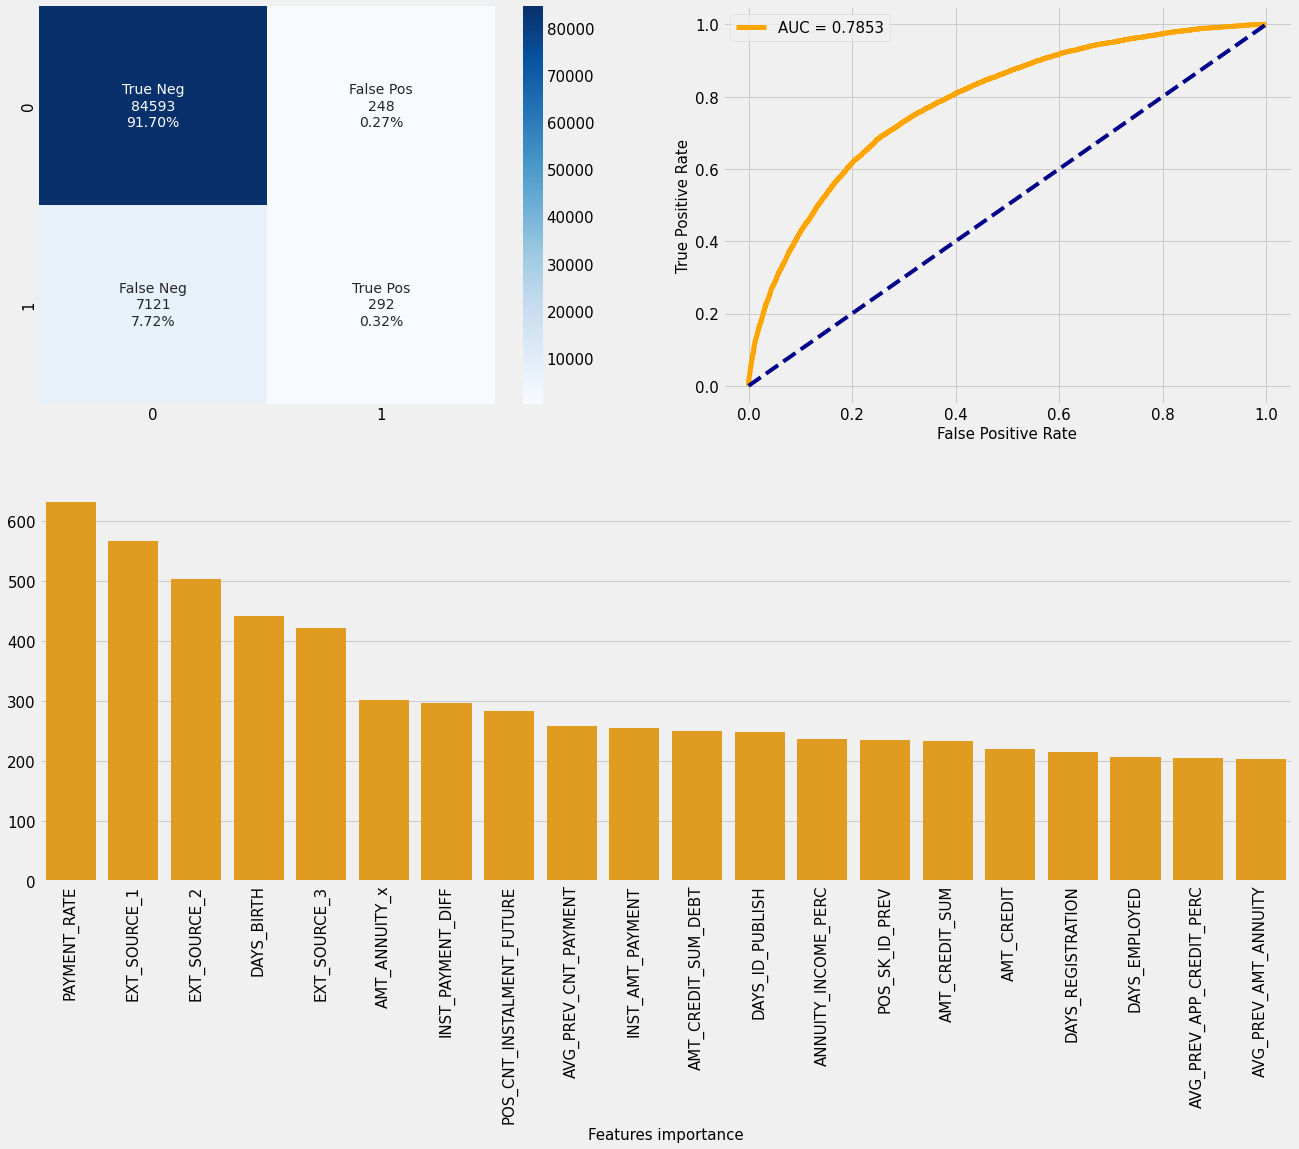

In [141]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [142]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.27%
False Neg: 7.72%


(0.0026882303206365037, 0.0771890649727925)

In [164]:
sorted_idx

array([205,  18,  19,   8,  20,   5, 207, 193,  91, 189,  59,  11, 204,
       190,  58,   4,  10,   9, 206,  81, 201,   6, 209,  50,  54, 195,
       183,  90,   7, 202,  57,  94,  86,  55,  60,  84,  62,  56, 176,
       110, 177,  95, 196, 188,   3, 149, 184,  89, 191,  92, 185, 203,
        85,  88,  74, 119, 187,  77, 192,  78,  72, 186, 210,  96,  71,
         1, 120,  64, 108, 152, 113, 216,  82, 103, 157, 164,  70,  12,
        83, 198,  15,  73,  93,  51, 115,  46, 101, 143,  16, 173,  63,
       211,  48, 150, 151, 174,  65, 165,  40,  31,  47, 155, 214, 160,
        61,   0, 172,  17, 179, 166, 194, 158, 142, 105, 138,  30,  38,
       148, 124, 111,  22, 100,  79, 128,  42, 121, 200, 134, 139,  26,
       122, 109,  49, 104, 145,  29, 117, 140,  53,  52, 102, 154, 170,
       230, 146, 215,  80, 171, 223, 144,  13, 137,  66,  28,  39, 182,
        97, 169,  76,  23, 180, 224, 167,  21,  37,  45,  44, 112, 125,
       135, 163, 220, 133, 212, 141, 159, 118, 153, 222,  99,  4

In [143]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['PAYMENT_RATE', 631]
['EXT_SOURCE_1', 567]
['EXT_SOURCE_2', 503]
['DAYS_BIRTH', 442]
['EXT_SOURCE_3', 422]
['AMT_ANNUITY_x', 302]
['INST_PAYMENT_DIFF', 296]
['POS_CNT_INSTALMENT_FUTURE', 284]
['AVG_PREV_CNT_PAYMENT', 258]
['INST_AMT_PAYMENT', 255]
['AMT_CREDIT_SUM_DEBT', 250]
['DAYS_ID_PUBLISH', 248]
['ANNUITY_INCOME_PERC', 236]
['POS_SK_ID_PREV', 235]
['AMT_CREDIT_SUM', 233]
['AMT_CREDIT', 220]
['DAYS_REGISTRATION', 215]
['DAYS_EMPLOYED', 206]
['AVG_PREV_APP_CREDIT_PERC', 205]
['AVG_PREV_AMT_ANNUITY', 203]
['DAYS_EMPLOYED_PERC', 190]
['AMT_GOODS_PRICE', 190]
['INST_DBD', 190]
['DAYS_LAST_PHONE_CHANGE', 187]
['DAYS_CREDIT', 182]
['POS_SK_DPD_DEF', 179]
['INST_SK_ID_PREV', 173]
['AVG_PREV_SELLERPLACE_AREA', 164]
['REGION_POPULATION_RELATIVE', 164]
['INCOME_CREDIT_PERC', 162]
['AMT_CREDIT_MAX_OVERDUE', 162]
['AVG_PREV_DAYS_LAST_DUE_1ST_VERSION', 161]
['AVG_PREV_HOUR_APPR_PROCESS_START', 155]
['DAYS_CREDIT_ENDDATE', 144]
['AMT_CREDIT_SUM_LIMIT', 140]
['AVG_PREV_AMT_DOWN_PAYMENT', 140]
['

In [145]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
    }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [147]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(), algo=tpe.suggest)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2022-07-05 04:32:01.098 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:32:01.098 INFO    hyperopt.tpe: TPE using 0 trials


  3%|▎         | 1/30 [04:09<2:00:40, 249.66s/trial, best loss: 0.2248667754978413]

2022-07-05 04:36:10.757 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:36:10.757 INFO    hyperopt.tpe: TPE using 1/1 trials with best loss 0.224867


  7%|▋         | 2/30 [06:14<1:22:20, 176.43s/trial, best loss: 0.2248667754978413]

2022-07-05 04:38:15.939 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010050 seconds
2022-07-05 04:38:15.939 INFO    hyperopt.tpe: TPE using 2/2 trials with best loss 0.224867


 10%|█         | 3/30 [09:17<1:20:35, 179.08s/trial, best loss: 0.2248667754978413]

2022-07-05 04:41:18.160 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:41:18.160 INFO    hyperopt.tpe: TPE using 3/3 trials with best loss 0.224867


 13%|█▎        | 4/30 [14:07<1:36:39, 223.07s/trial, best loss: 0.22330945299670302]

2022-07-05 04:46:08.656 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:46:08.664 INFO    hyperopt.tpe: TPE using 4/4 trials with best loss 0.223309


 17%|█▋        | 5/30 [15:49<1:14:46, 179.47s/trial, best loss: 0.22330945299670302]

2022-07-05 04:47:50.836 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008027 seconds
2022-07-05 04:47:50.838 INFO    hyperopt.tpe: TPE using 5/5 trials with best loss 0.223309


 20%|██        | 6/30 [19:50<1:20:05, 200.22s/trial, best loss: 0.22330945299670302]

2022-07-05 04:51:51.326 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:51:51.326 INFO    hyperopt.tpe: TPE using 6/6 trials with best loss 0.223309


 23%|██▎       | 7/30 [22:41<1:13:03, 190.60s/trial, best loss: 0.21896494258330512]

2022-07-05 04:54:42.111 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:54:42.119 INFO    hyperopt.tpe: TPE using 7/7 trials with best loss 0.218965


 27%|██▋       | 8/30 [23:35<54:02, 147.37s/trial, best loss: 0.21896494258330512]  

2022-07-05 04:55:36.909 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:55:36.909 INFO    hyperopt.tpe: TPE using 8/8 trials with best loss 0.218965


 30%|███       | 9/30 [25:12<46:01, 131.51s/trial, best loss: 0.21896494258330512]

2022-07-05 04:57:13.562 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:57:13.562 INFO    hyperopt.tpe: TPE using 9/9 trials with best loss 0.218965


 33%|███▎      | 10/30 [25:55<34:46, 104.33s/trial, best loss: 0.21896494258330512]

2022-07-05 04:57:57.038 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008035 seconds
2022-07-05 04:57:57.040 INFO    hyperopt.tpe: TPE using 10/10 trials with best loss 0.218965


 37%|███▋      | 11/30 [27:44<33:28, 105.72s/trial, best loss: 0.21896494258330512]

2022-07-05 04:59:45.908 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 04:59:45.908 INFO    hyperopt.tpe: TPE using 11/11 trials with best loss 0.218965


 40%|████      | 12/30 [29:41<32:40, 108.91s/trial, best loss: 0.21896494258330512]

2022-07-05 05:01:42.105 INFO    hyperopt.tpe: build_posterior_wrapper took 0.002025 seconds
2022-07-05 05:01:42.105 INFO    hyperopt.tpe: TPE using 12/12 trials with best loss 0.218965


 43%|████▎     | 13/30 [35:00<48:53, 172.56s/trial, best loss: 0.21896494258330512]

2022-07-05 05:07:01.119 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:07:01.128 INFO    hyperopt.tpe: TPE using 13/13 trials with best loss 0.218965


 47%|████▋     | 14/30 [38:41<49:56, 187.26s/trial, best loss: 0.21896494258330512]

2022-07-05 05:10:42.355 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:10:42.355 INFO    hyperopt.tpe: TPE using 14/14 trials with best loss 0.218965


 50%|█████     | 15/30 [41:47<46:42, 186.83s/trial, best loss: 0.21896494258330512]

2022-07-05 05:13:48.186 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:13:48.194 INFO    hyperopt.tpe: TPE using 15/15 trials with best loss 0.218965


 53%|█████▎    | 16/30 [43:17<36:47, 157.70s/trial, best loss: 0.21896494258330512]

2022-07-05 05:15:18.246 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:15:18.246 INFO    hyperopt.tpe: TPE using 16/16 trials with best loss 0.218965


 57%|█████▋    | 17/30 [45:22<32:04, 148.03s/trial, best loss: 0.21896494258330512]

2022-07-05 05:17:23.783 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006553 seconds
2022-07-05 05:17:23.785 INFO    hyperopt.tpe: TPE using 17/17 trials with best loss 0.218965


 60%|██████    | 18/30 [46:26<24:31, 122.61s/trial, best loss: 0.21896494258330512]

2022-07-05 05:18:27.235 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010106 seconds
2022-07-05 05:18:27.235 INFO    hyperopt.tpe: TPE using 18/18 trials with best loss 0.218965


 63%|██████▎   | 19/30 [48:28<22:28, 122.57s/trial, best loss: 0.21896494258330512]

2022-07-05 05:20:29.717 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008096 seconds
2022-07-05 05:20:29.719 INFO    hyperopt.tpe: TPE using 19/19 trials with best loss 0.218965


 67%|██████▋   | 20/30 [49:59<18:50, 113.10s/trial, best loss: 0.21896494258330512]

2022-07-05 05:22:00.717 INFO    hyperopt.tpe: build_posterior_wrapper took 0.004504 seconds
2022-07-05 05:22:00.720 INFO    hyperopt.tpe: TPE using 20/20 trials with best loss 0.218965


 70%|███████   | 21/30 [52:25<18:26, 122.93s/trial, best loss: 0.21896494258330512]

2022-07-05 05:24:26.571 INFO    hyperopt.tpe: build_posterior_wrapper took 0.002016 seconds
2022-07-05 05:24:26.578 INFO    hyperopt.tpe: TPE using 21/21 trials with best loss 0.218965


 73%|███████▎  | 22/30 [56:21<20:54, 156.82s/trial, best loss: 0.21896494258330512]

2022-07-05 05:28:22.417 INFO    hyperopt.tpe: build_posterior_wrapper took 0.002027 seconds
2022-07-05 05:28:22.417 INFO    hyperopt.tpe: TPE using 22/22 trials with best loss 0.218965


 77%|███████▋  | 23/30 [1:00:02<20:33, 176.28s/trial, best loss: 0.21896494258330512]

2022-07-05 05:32:04.094 INFO    hyperopt.tpe: build_posterior_wrapper took 0.012040 seconds
2022-07-05 05:32:04.094 INFO    hyperopt.tpe: TPE using 23/23 trials with best loss 0.218965


 80%|████████  | 24/30 [1:03:40<18:51, 188.60s/trial, best loss: 0.21896494258330512]

2022-07-05 05:35:41.443 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008742 seconds
2022-07-05 05:35:41.446 INFO    hyperopt.tpe: TPE using 24/24 trials with best loss 0.218965


 83%|████████▎ | 25/30 [1:06:08<14:42, 176.53s/trial, best loss: 0.21896494258330512]

2022-07-05 05:38:09.815 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:38:09.815 INFO    hyperopt.tpe: TPE using 25/25 trials with best loss 0.218965


 87%|████████▋ | 26/30 [1:09:02<11:42, 175.68s/trial, best loss: 0.21896494258330512]

2022-07-05 05:41:03.507 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008057 seconds
2022-07-05 05:41:03.509 INFO    hyperopt.tpe: TPE using 26/26 trials with best loss 0.218965


 90%|█████████ | 27/30 [1:13:02<09:45, 195.10s/trial, best loss: 0.21846594691736598]

2022-07-05 05:45:03.899 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:45:03.899 INFO    hyperopt.tpe: TPE using 27/27 trials with best loss 0.218466


 93%|█████████▎| 28/30 [1:16:07<06:23, 191.92s/trial, best loss: 0.21846594691736598]

2022-07-05 05:48:08.400 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:48:08.408 INFO    hyperopt.tpe: TPE using 28/28 trials with best loss 0.218466


 97%|█████████▋| 29/30 [1:19:32<03:15, 195.89s/trial, best loss: 0.21846594691736598]

2022-07-05 05:51:33.556 INFO    hyperopt.tpe: build_posterior_wrapper took 0.000000 seconds
2022-07-05 05:51:33.556 INFO    hyperopt.tpe: TPE using 29/29 trials with best loss 0.218466


100%|██████████| 30/30 [1:22:23<00:00, 164.79s/trial, best loss: 0.21846594691736598]
Wall time: 1h 22min 23s


In [152]:
%%time
lgbm = LGBMClassifier(
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    reg_lambda= best['reg_lambda'])

lgbm.fit(X_train_selected, y_train)
#pickle.dump(lgbm, open("/content/gdrive/My Drive/Colab Notebooks/p7_00_models/LGBMClassifier.pkl", "wb"))

Wall time: 49.9 s


LGBMClassifier(colsample_bytree=0.6778015491086647,
               learning_rate=0.021737693636634133, max_depth=6,
               n_estimators=600, reg_lambda=1.85139084011759)

In [153]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.784129


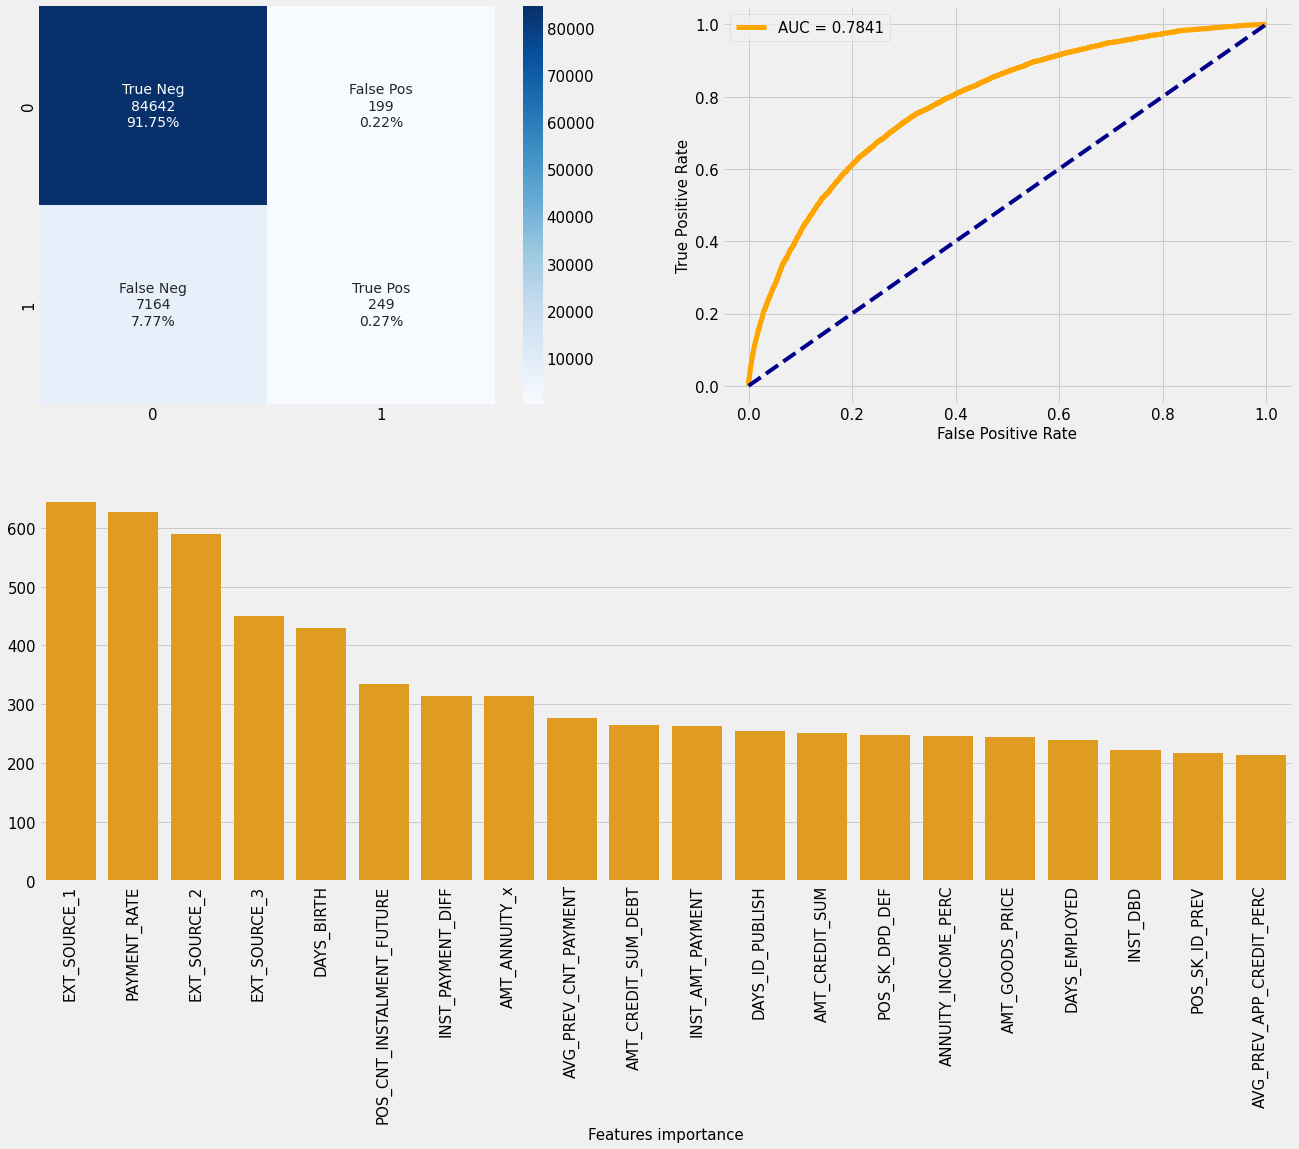

In [154]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [155]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.22%
False Neg: 7.77%


(0.002157088039543001, 0.07765516942354803)

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 